# Trabalho Final - Machine Learning

* Matheus Souza - 358585
* Lucian da Silva - 359082
* André Aragão - 359323
* Maurício Mourão - 359495

Neste trabalho, como parte do time de analistas da Quantum Finance, vocês deverão explorar uma base de dados originalmente utilizada para classificação de score de crédito, disponível no Kaggle (https://www.kaggle.com/datasets/parisrohan/credit-score-classification), utilizando técnicas de Análise Exploratória de Dados (EDA) e algoritmos de Machine Learning supervisionados.


O objetivo é aplicar e interpretar os resultados obtidos, assim como criar um sistema que gere valor a partir da análise da base de dados.

**Modelo de Classificação Supervisionada**


Desenvolver um modelo de classificação supervisionada para prever a classificação de crédito dos indivíduos presentes na base.


Passos esperados:

1. Realizar uma análise exploratória dos dados (EDA) para entender as características principais da base e as relações entre variáveis; 2 pontos

2. Implementar um pipeline de modelo de classificação usando Random Forest, XGBoost e LightGBM. Use GridSearch para otimizar os parametros de cada modelo; 4 pontos

3. Avaliar os resultados utilizando a métrica mais adequada e **justifique** sua escolha; 2 pontos

4. Apresentar os resultados, indicando a métrica no conjunto de treino (train.csv) e explicar como o modelo pode ser utilizado para decisões financeiras. 2 pontos


Entregáveis:

1. Este jupyter notebook executado e com os resultados aparentes (não serão aceitos outros formatos)

## Configuração do Ambiente



> ATENÇÃO: Para melhor performance no XGBoost, configurar o Google Colab para executar com acelerador de hardware do tipo **GPUs: T4**

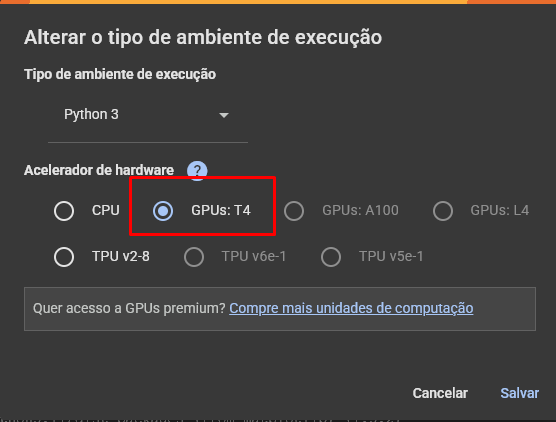


In [1]:
# Instalando as bibliotecas, caso ainda não estejam instaladas
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm

In [2]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import warnings
import tempfile
import kagglehub
import shutil
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from joblib import Memory

# Configurações de visualização
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)

## Carregamento dos Dados
Importar as bases direto do kaggle e migrar elas para a pasta content

In [3]:
# Baixa os dados com kagglehub (salva em /kaggle/input/...)
path = kagglehub.dataset_download("parisrohan/credit-score-classification")

# Define destino
destination = "/content"

# Copia todos os arquivos e subpastas para o destino
shutil.copytree(path, destination, dirs_exist_ok=True)

print("Arquivos copiados para:", destination)
print("Conteúdo:", os.listdir(destination))


Arquivos copiados para: /content
Conteúdo: ['.config', 'train.csv', 'test.csv', 'sample_data']


In [4]:
# Carregamento dos dados
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Dimensões dos datasets
print(f"Dimensões do conjunto de treino: {train_df.shape}")
print(f"Dimensões do conjunto de teste: {test_df.shape}")

Dimensões do conjunto de treino: (100000, 28)
Dimensões do conjunto de teste: (50000, 27)


# 1. Análise Exploratória dos Dados (EDA)

Vamos realizar uma análise exploratória completa para entender as características principais da base e as relações entre variáveis.

## 1.1 Visão Geral dos Dados

In [5]:
# Visualizando as primeiras linhas do conjunto de treino
train_df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [6]:
# Visualizando as primeiras linhas do conjunto de teste
test_df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,13.27,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,12.27,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,11.27,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,1,5.42,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


In [7]:
# Informações sobre os tipos de dados
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [8]:
# Estatísticas descritivas do conjunto de treino
train_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,100000,100000,0x25fb6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_ID,100000,12500,CUS_0x942c,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,100000,8,January,12500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name,90015,10139,Langep,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,100000,1788,38,2833,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SSN,100000,12501,#F%$D@*&8,5572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,100000,16,_______,7062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual_Income,100000,18940,20867.67,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monthly_Inhand_Salary,84998.0,NaN,NaN,NaN,4194.17085,3183.686167,303.645417,1625.568229,3093.745,5957.448333,15204.633333
Num_Bank_Accounts,100000.0,NaN,NaN,NaN,17.09128,117.404834,-1.0,3.0,6.0,7.0,1798.0


## 1.2 Análise da Variável Alvo (Credit_Score)

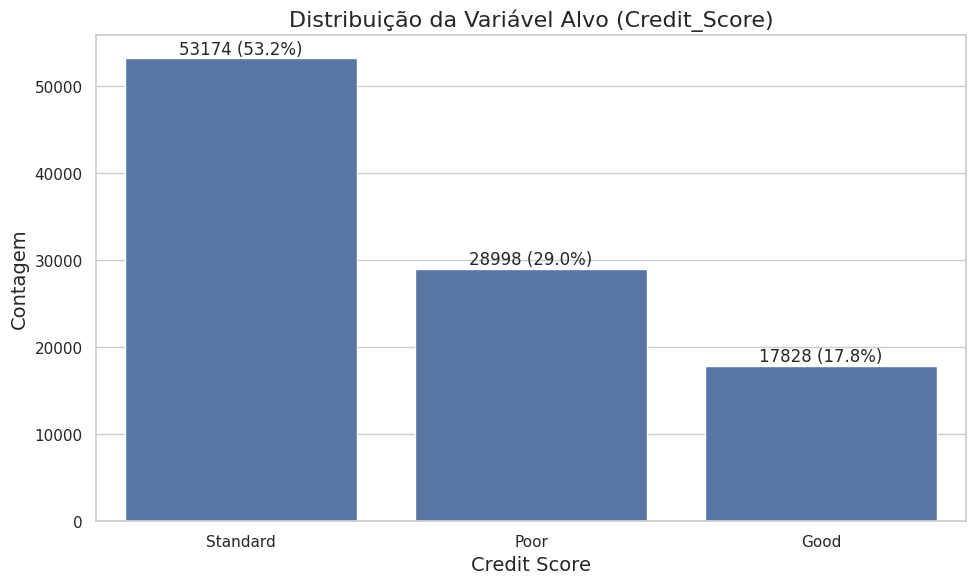

Valores únicos da variável Credit_Score:
['Good' 'Standard' 'Poor']


In [9]:
# Verificando a distribuição da variável alvo
plt.figure(figsize=(10, 6))
target_counts = train_df['Credit_Score'].value_counts()
ax = sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribuição da Variável Alvo (Credit_Score)', fontsize=16)
plt.xlabel('Credit Score', fontsize=14)
plt.ylabel('Contagem', fontsize=14)

# Adicionar rótulos de contagem em cada barra
for i, count in enumerate(target_counts.values):
    ax.text(i, count + 50, f'{count} ({count/len(train_df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=12)

plt.show()

# Verificando os valores únicos da variável alvo
print("Valores únicos da variável Credit_Score:")
print(train_df['Credit_Score'].unique())

## 1.3 Análise de Valores Ausentes

In [10]:
# Verificando valores ausentes no conjunto de treino
missing_train = train_df.isnull().sum()
missing_train_percent = (missing_train / len(train_df)) * 100
missing_train_df = pd.DataFrame({'Contagem': missing_train, 'Percentual (%)': missing_train_percent})
missing_train_df = missing_train_df[missing_train_df['Contagem'] > 0].sort_values('Percentual (%)', ascending=False)

print("Valores ausentes no conjunto de treino:")
if len(missing_train_df) > 0:
    display(missing_train_df)
else:
    print("Não há valores ausentes no conjunto de treino.")

# Verificando valores ausentes no conjunto de teste
missing_test = test_df.isnull().sum()
missing_test_percent = (missing_test / len(test_df)) * 100
missing_test_df = pd.DataFrame({'Contagem': missing_test, 'Percentual (%)': missing_test_percent})
missing_test_df = missing_test_df[missing_test_df['Contagem'] > 0].sort_values('Percentual (%)', ascending=False)

print("\nValores ausentes no conjunto de teste:")
if len(missing_test_df) > 0:
    display(missing_test_df)
else:
    print("Não há valores ausentes no conjunto de teste.")

Valores ausentes no conjunto de treino:


,Contagem,Percentual (%)
Monthly_Inhand_Salary,15002,15.002
Type_of_Loan,11408,11.408
Name,9985,9.985
Credit_History_Age,9030,9.030
Num_of_Delayed_Payment,7002,7.002
Amount_invested_monthly,4479,4.479
Num_Credit_Inquiries,1965,1.965
Monthly_Balance,1200,1.200



Valores ausentes no conjunto de teste:


,Contagem,Percentual (%)
Monthly_Inhand_Salary,7498,14.996
Type_of_Loan,5704,11.408
Name,5015,10.030
Credit_History_Age,4470,8.940
Num_of_Delayed_Payment,3498,6.996
Amount_invested_monthly,2271,4.542
Num_Credit_Inquiries,1035,2.070
Monthly_Balance,562,1.124


In [11]:
# Verificando valores especiais que podem representar dados ausentes
special_values = ['_', 'NA', '!@9#%8', '#F%$D@*&8']

# Função para verificar valores especiais em cada coluna
def check_special_values(df, special_values):
    result = {}
    for col in df.columns:
        col_special = {}
        for val in special_values:
            count = (df[col] == val).sum()
            if count > 0:
                col_special[val] = count
        if col_special:
            result[col] = col_special
    return result

# Verificando valores especiais no conjunto de treino
special_train = check_special_values(train_df, special_values)
print("Valores especiais no conjunto de treino:")
for col, vals in special_train.items():
    print(f"{col}: {vals}")

# Verificando valores especiais no conjunto de teste
special_test = check_special_values(test_df, special_values)
print("\nValores especiais no conjunto de teste:")
for col, vals in special_test.items():
    print(f"{col}: {vals}")

Valores especiais no conjunto de treino:
SSN: {'#F%$D@*&8': np.int64(5572)}
Changed_Credit_Limit: {'_': np.int64(2091)}
Credit_Mix: {'_': np.int64(20195)}
Payment_Behaviour: {'!@9#%8': np.int64(7600)}

Valores especiais no conjunto de teste:
SSN: {'#F%$D@*&8': np.int64(2828)}
Changed_Credit_Limit: {'_': np.int64(1059)}
Credit_Mix: {'_': np.int64(9805)}
Payment_Behaviour: {'!@9#%8': np.int64(3800)}


## 1.4 Análise de Variáveis Numéricas

Colunas numéricas: ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Total_EMI_per_month']


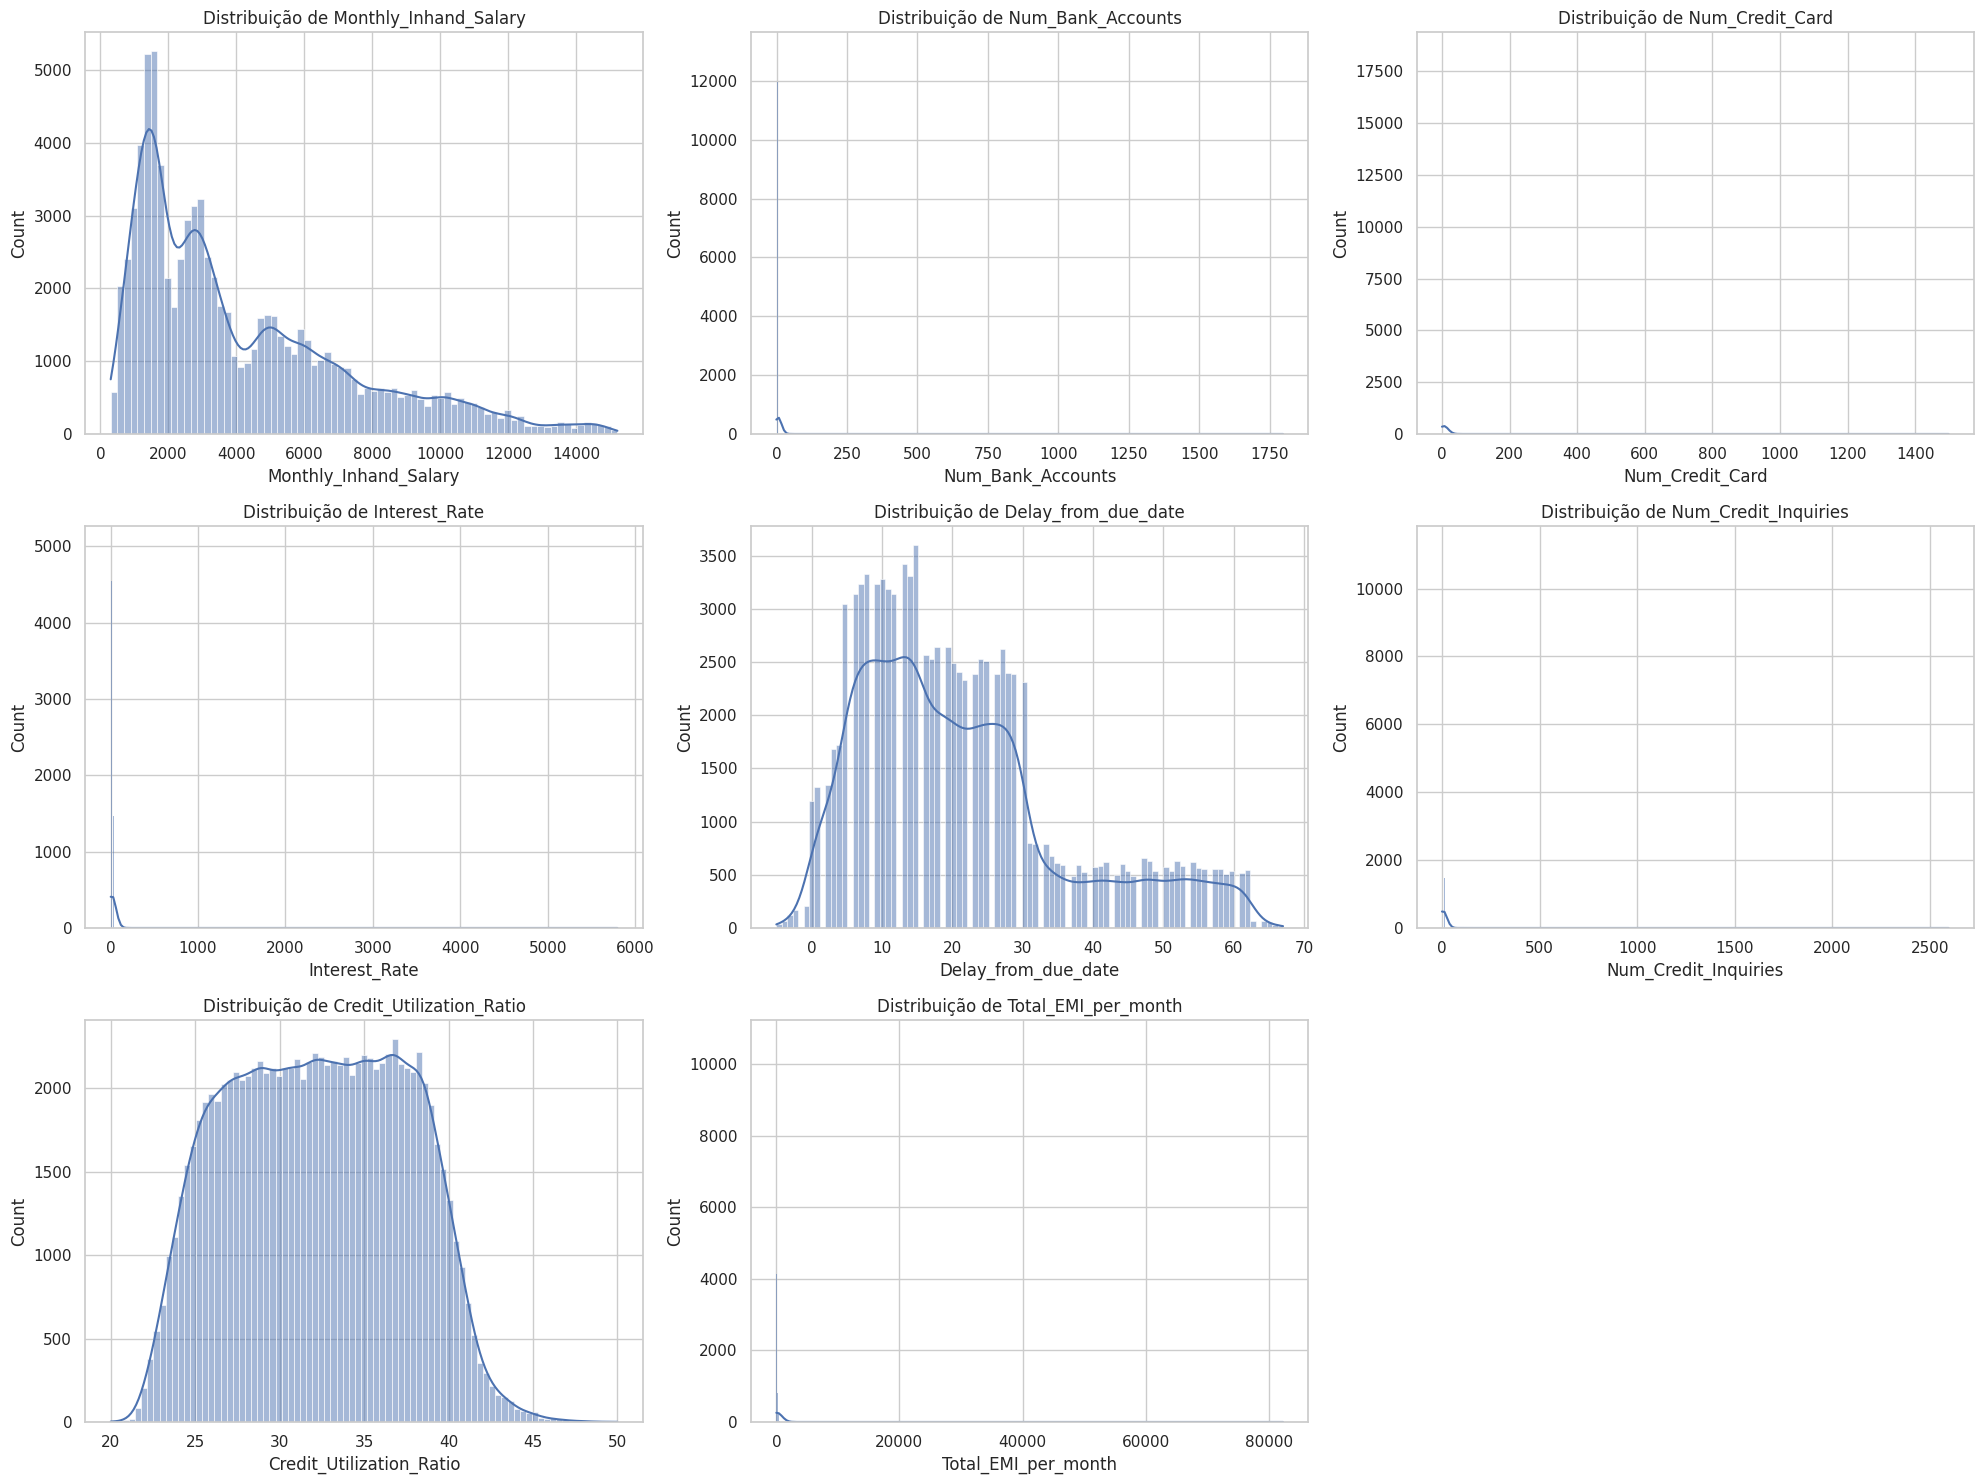

In [12]:
# Identificando colunas numéricas
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['ID']]

print(f"Colunas numéricas: {numeric_cols}")

# Histogramas para variáveis numéricas
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols[:9], 1):  # Limitando a 9 gráficos por vez
    plt.subplot(3, 3, i)
    sns.histplot(train_df[col].dropna(), kde=True)
    plt.title(f'Distribuição de {col}')
    plt.tight_layout()
plt.show()

if len(numeric_cols) > 9:
    plt.figure(figsize=(20, 15))
    for i, col in enumerate(numeric_cols[9:18], 1):
        plt.subplot(3, 3, i)
        sns.histplot(train_df[col].dropna(), kde=True)
        plt.title(f'Distribuição de {col}')
        plt.tight_layout()
    plt.show()

if len(numeric_cols) > 18:
    plt.figure(figsize=(20, 15))
    for i, col in enumerate(numeric_cols[18:], 1):
        plt.subplot(3, 3, i)
        sns.histplot(train_df[col].dropna(), kde=True)
        plt.title(f'Distribuição de {col}')
        plt.tight_layout()
    plt.show()

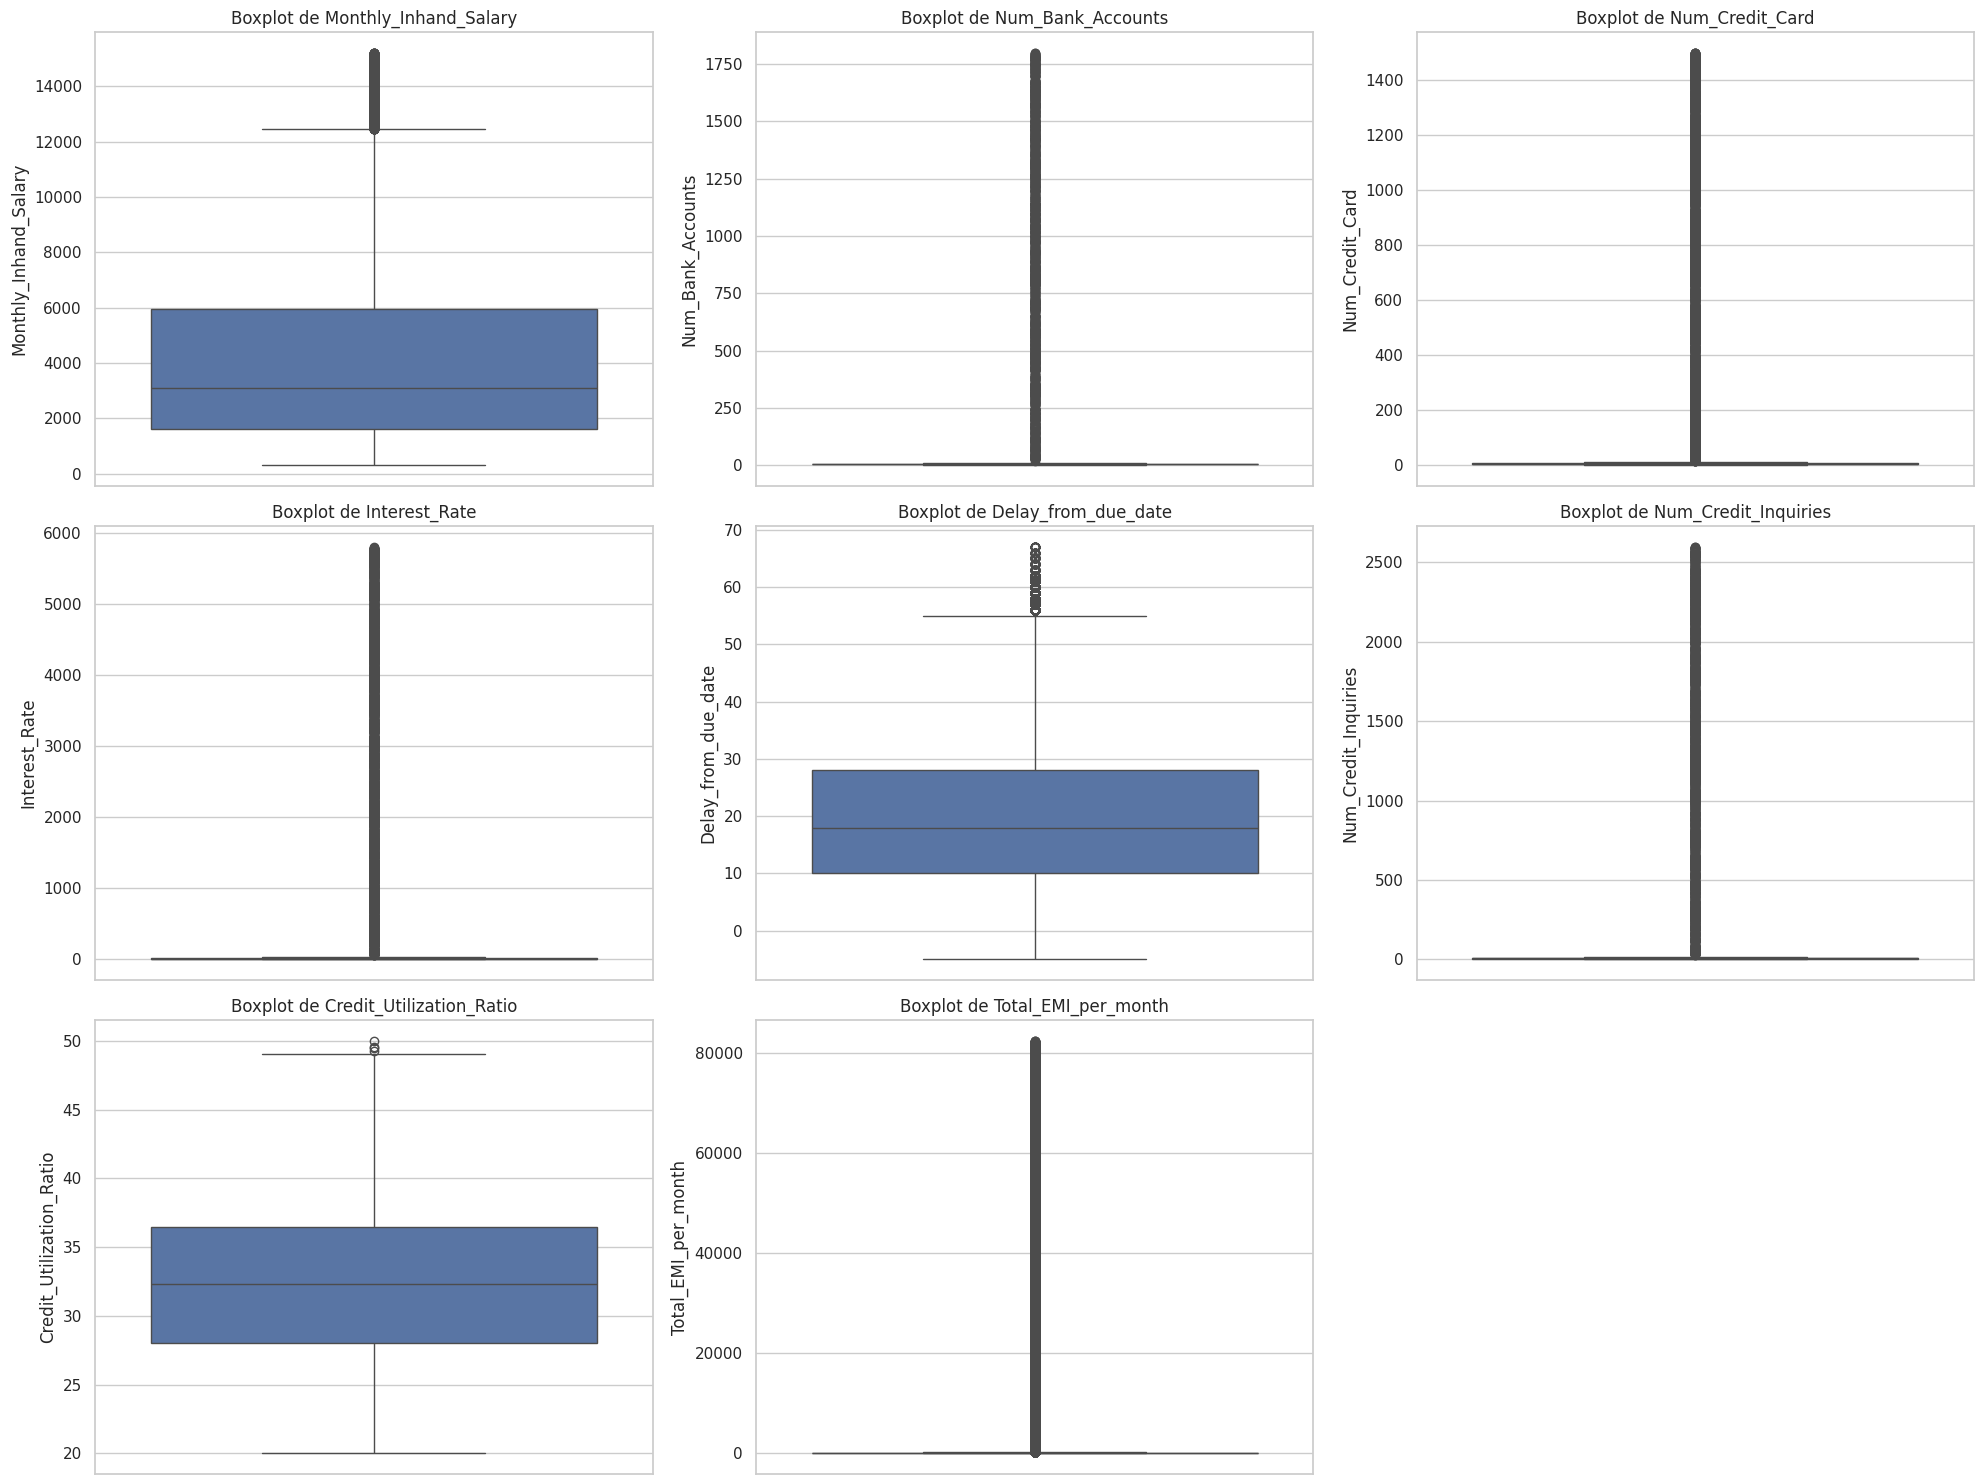

In [13]:
# Boxplots para identificar outliers em variáveis numéricas
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols[:9], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=train_df[col].dropna())
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()
plt.show()

if len(numeric_cols) > 9:
    plt.figure(figsize=(20, 15))
    for i, col in enumerate(numeric_cols[9:18], 1):
        plt.subplot(3, 3, i)
        sns.boxplot(y=train_df[col].dropna())
        plt.title(f'Boxplot de {col}')
        plt.tight_layout()
    plt.show()

if len(numeric_cols) > 18:
    plt.figure(figsize=(20, 15))
    for i, col in enumerate(numeric_cols[18:], 1):
        plt.subplot(3, 3, i)
        sns.boxplot(y=train_df[col].dropna())
        plt.title(f'Boxplot de {col}')
        plt.tight_layout()
    plt.show()

## 1.5 Análise de Variáveis Categóricas

Colunas categóricas: ['Month', 'Age', 'Occupation', 'Annual_Income', 'Num_of_Loan', 'Type_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_Score']


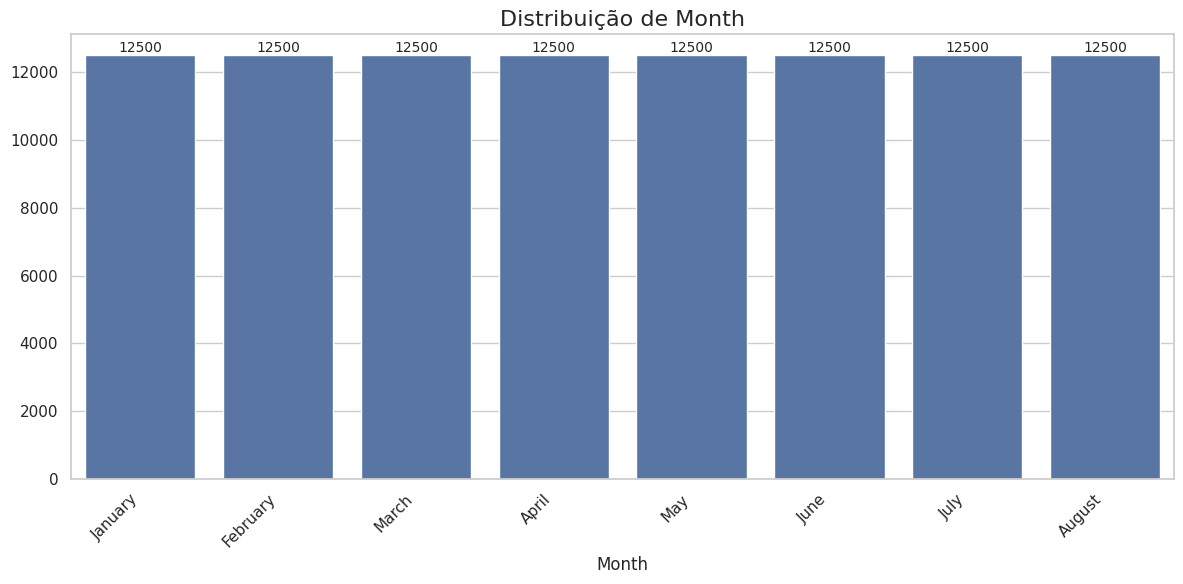


Valores únicos em Month:
Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: count, dtype: int64


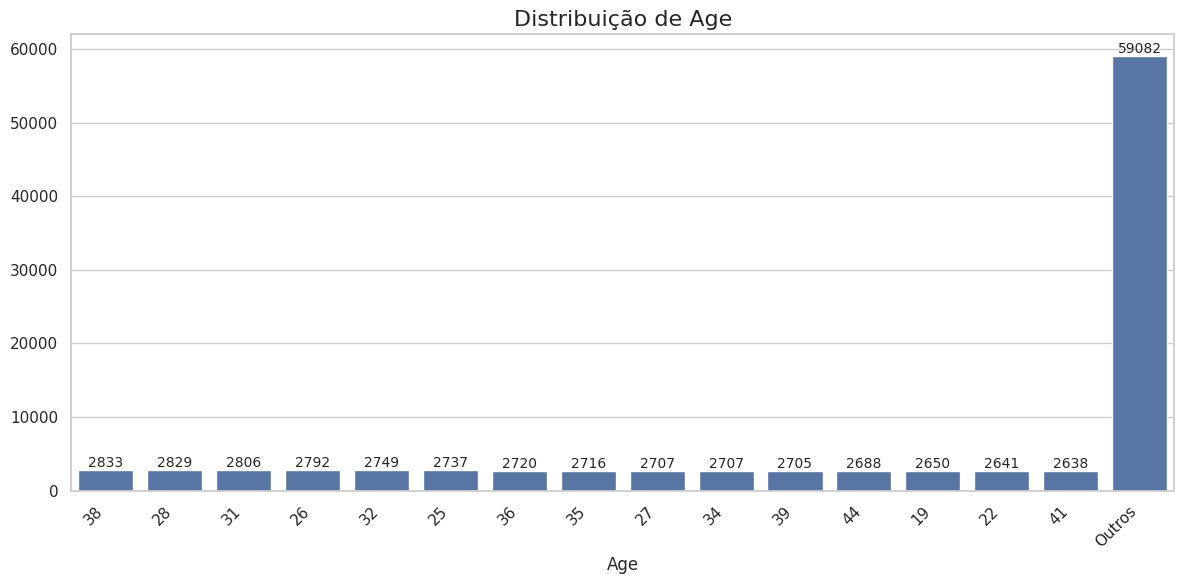


Valores únicos em Age:
Age
38         2833
28         2829
31         2806
26         2792
32         2749
25         2737
36         2720
35         2716
27         2707
34         2707
39         2705
44         2688
19         2650
22         2641
41         2638
Outros    59082
Name: count, dtype: int64


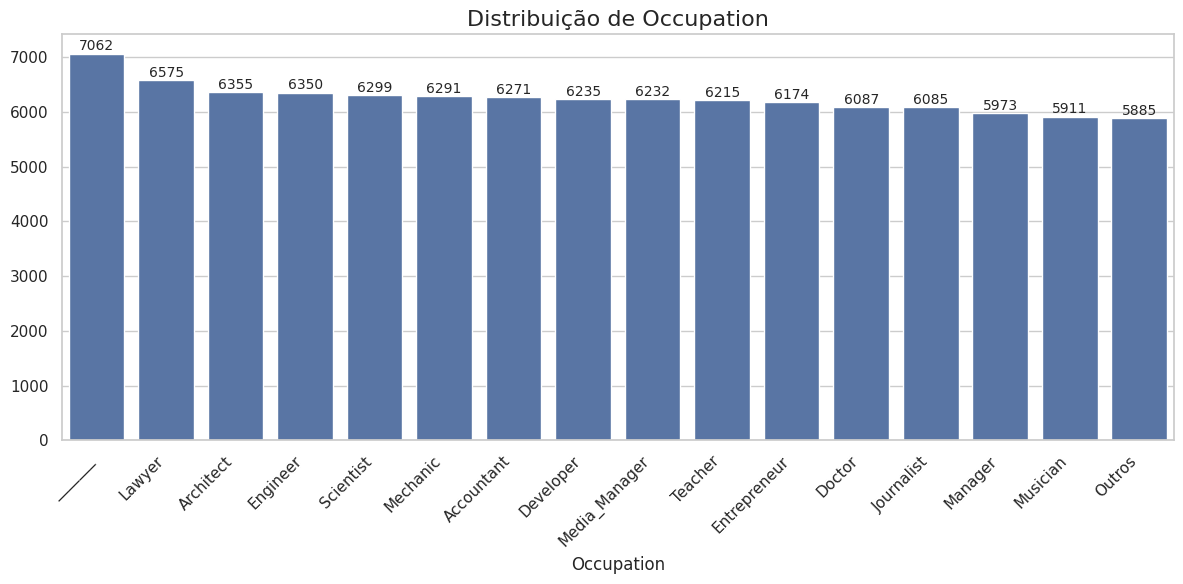


Valores únicos em Occupation:
Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Outros           5885
Name: count, dtype: int64


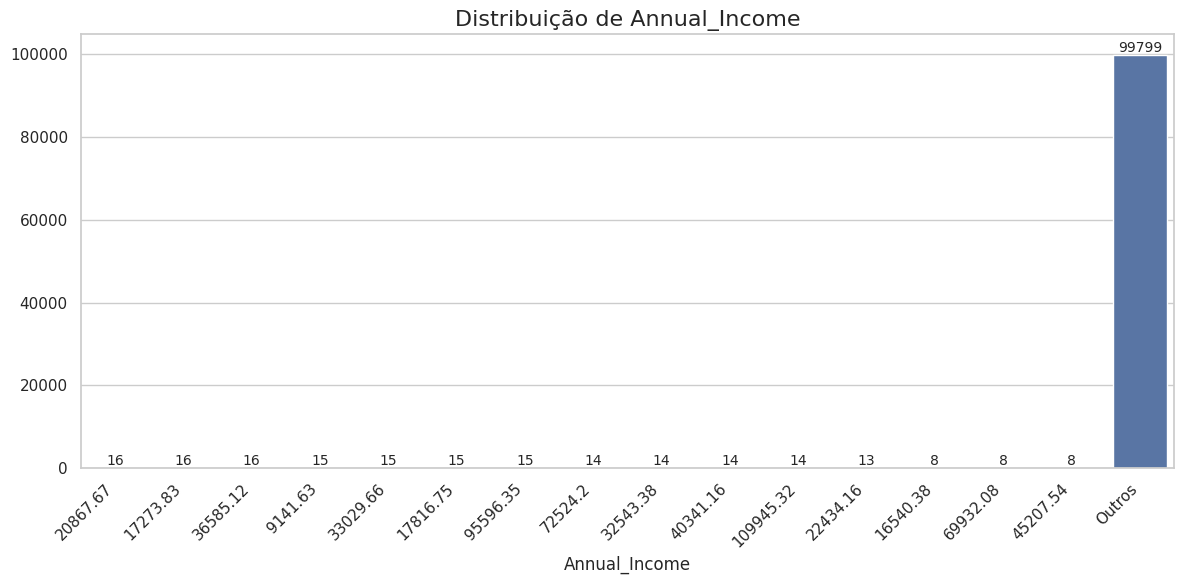


Valores únicos em Annual_Income:
Annual_Income
20867.67        16
17273.83        16
36585.12        16
9141.63         15
33029.66        15
17816.75        15
95596.35        15
72524.2         14
32543.38        14
40341.16        14
109945.32       14
22434.16        13
16540.38         8
69932.08         8
45207.54         8
Outros       99799
Name: count, dtype: int64


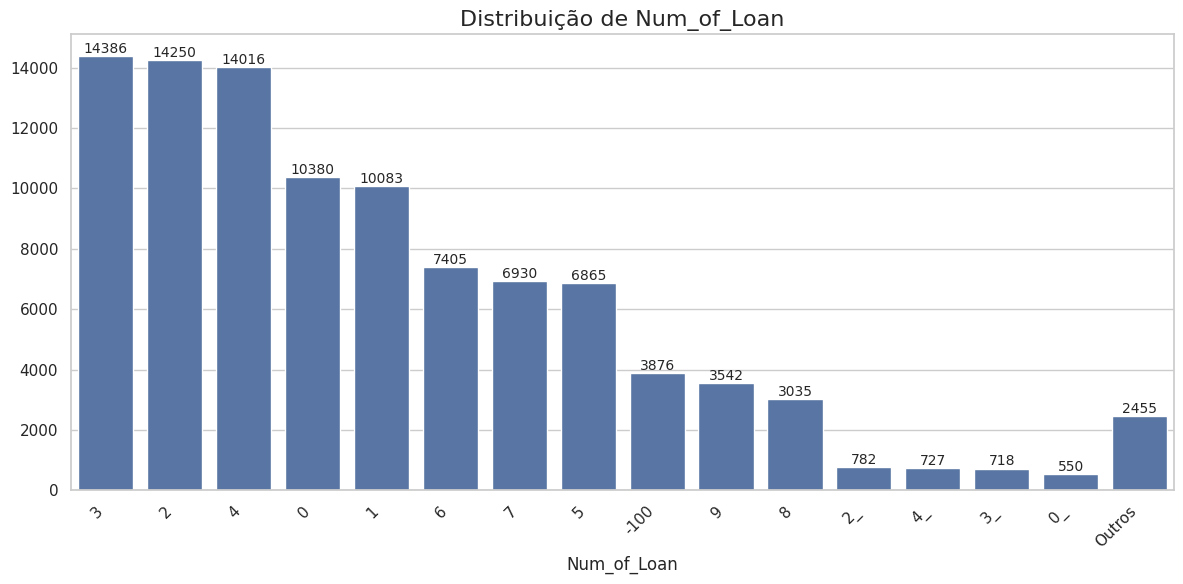


Valores únicos em Num_of_Loan:
Num_of_Loan
3         14386
2         14250
4         14016
0         10380
1         10083
6          7405
7          6930
5          6865
-100       3876
9          3542
8          3035
2_          782
4_          727
3_          718
0_          550
Outros     2455
Name: count, dtype: int64


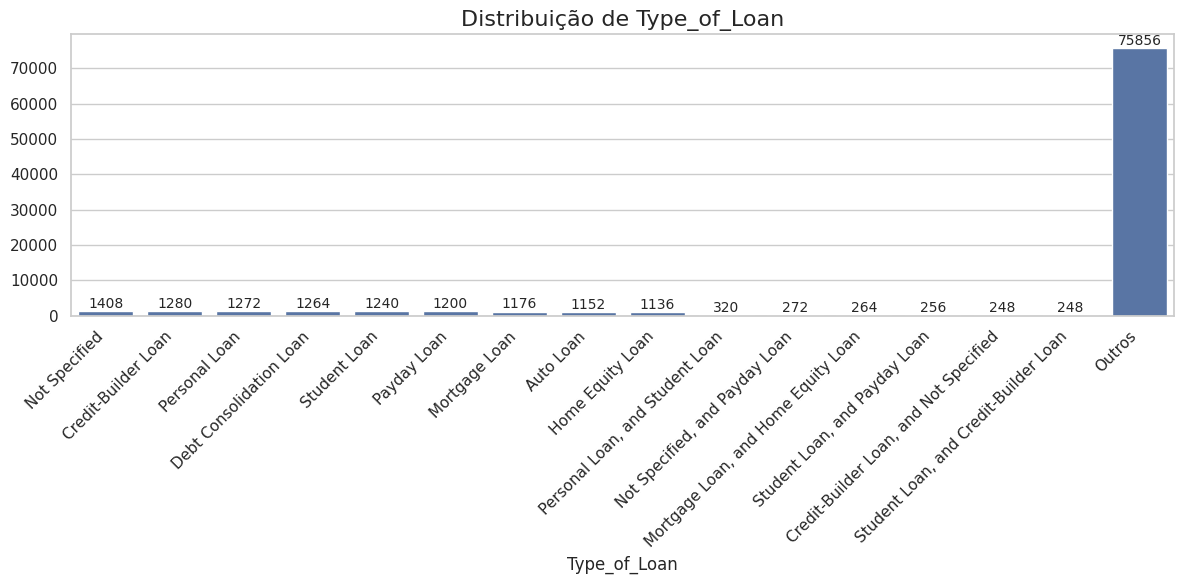


Valores únicos em Type_of_Loan:
Type_of_Loan
Not Specified                              1408
Credit-Builder Loan                        1280
Personal Loan                              1272
Debt Consolidation Loan                    1264
Student Loan                               1240
Payday Loan                                1200
Mortgage Loan                              1176
Auto Loan                                  1152
Home Equity Loan                           1136
Personal Loan, and Student Loan             320
Not Specified, and Payday Loan              272
Mortgage Loan, and Home Equity Loan         264
Student Loan, and Payday Loan               256
Credit-Builder Loan, and Not Specified      248
Student Loan, and Credit-Builder Loan       248
Outros                                    75856
Name: count, dtype: int64


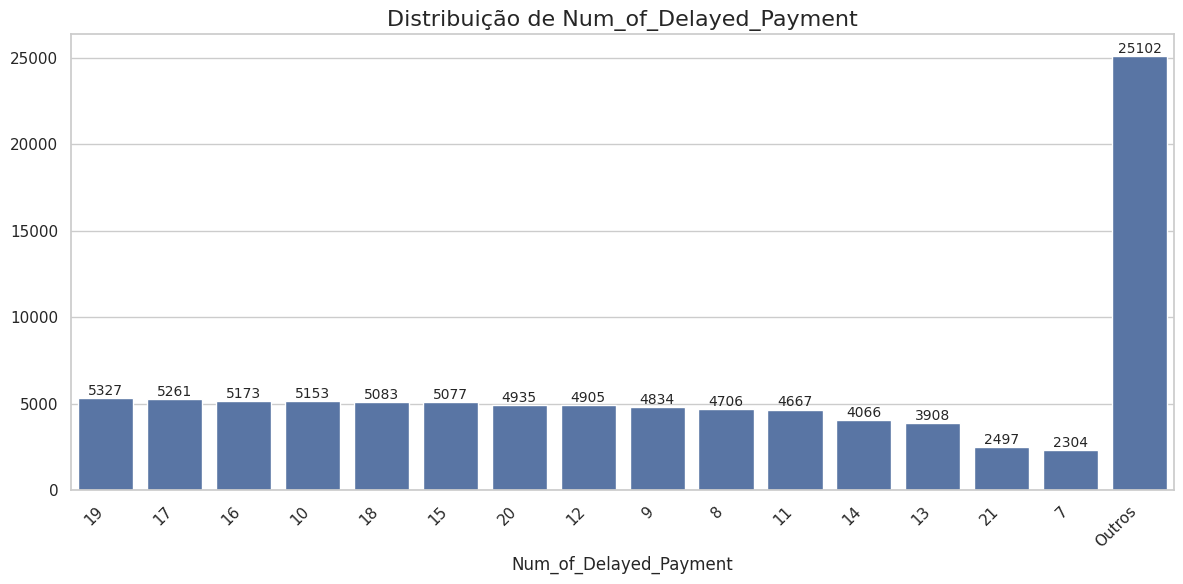


Valores únicos em Num_of_Delayed_Payment:
Num_of_Delayed_Payment
19         5327
17         5261
16         5173
10         5153
18         5083
15         5077
20         4935
12         4905
9          4834
8          4706
11         4667
14         4066
13         3908
21         2497
7          2304
Outros    25102
Name: count, dtype: int64


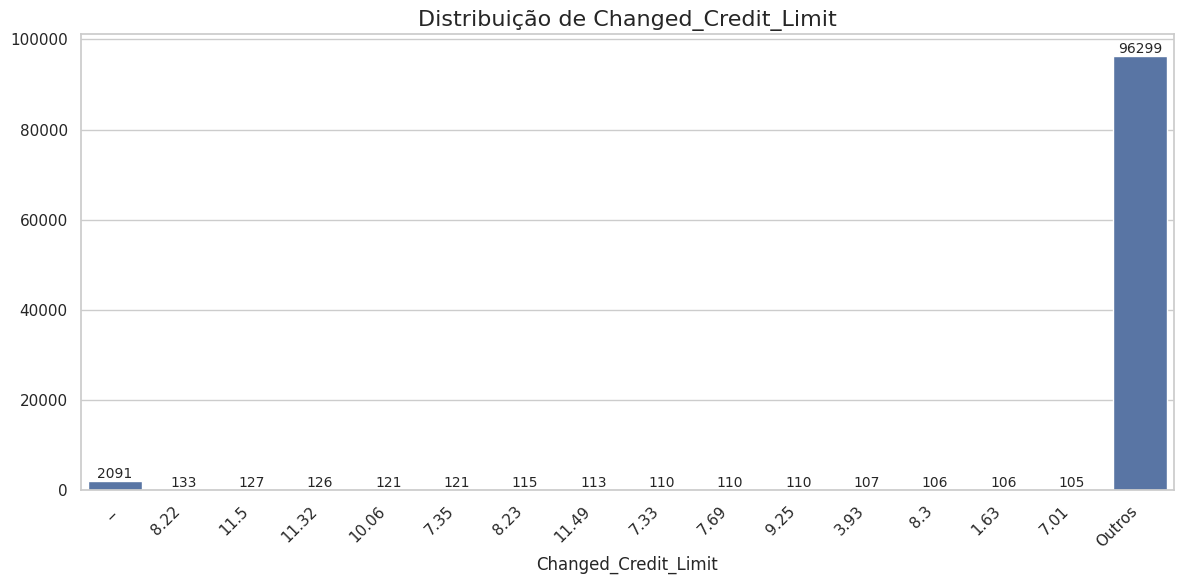


Valores únicos em Changed_Credit_Limit:
Changed_Credit_Limit
_          2091
8.22        133
11.5        127
11.32       126
10.06       121
7.35        121
8.23        115
11.49       113
7.33        110
7.69        110
9.25        110
3.93        107
8.3         106
1.63        106
7.01        105
Outros    96299
Name: count, dtype: int64


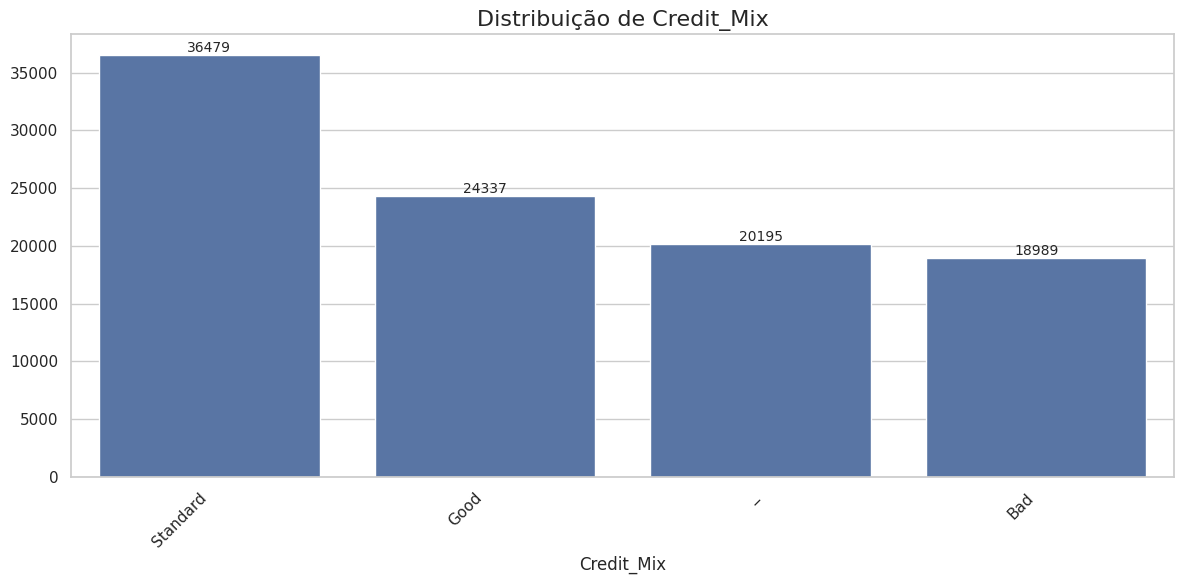


Valores únicos em Credit_Mix:
Credit_Mix
Standard    36479
Good        24337
_           20195
Bad         18989
Name: count, dtype: int64


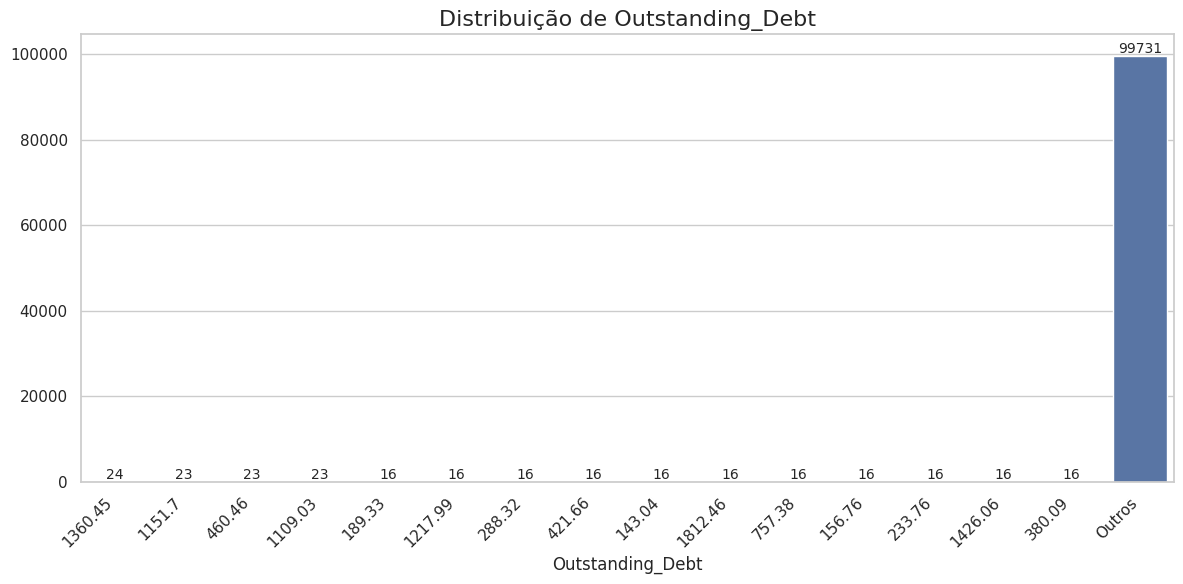


Valores únicos em Outstanding_Debt:
Outstanding_Debt
1360.45       24
1151.7        23
460.46        23
1109.03       23
189.33        16
1217.99       16
288.32        16
421.66        16
143.04        16
1812.46       16
757.38        16
156.76        16
233.76        16
1426.06       16
380.09        16
Outros     99731
Name: count, dtype: int64


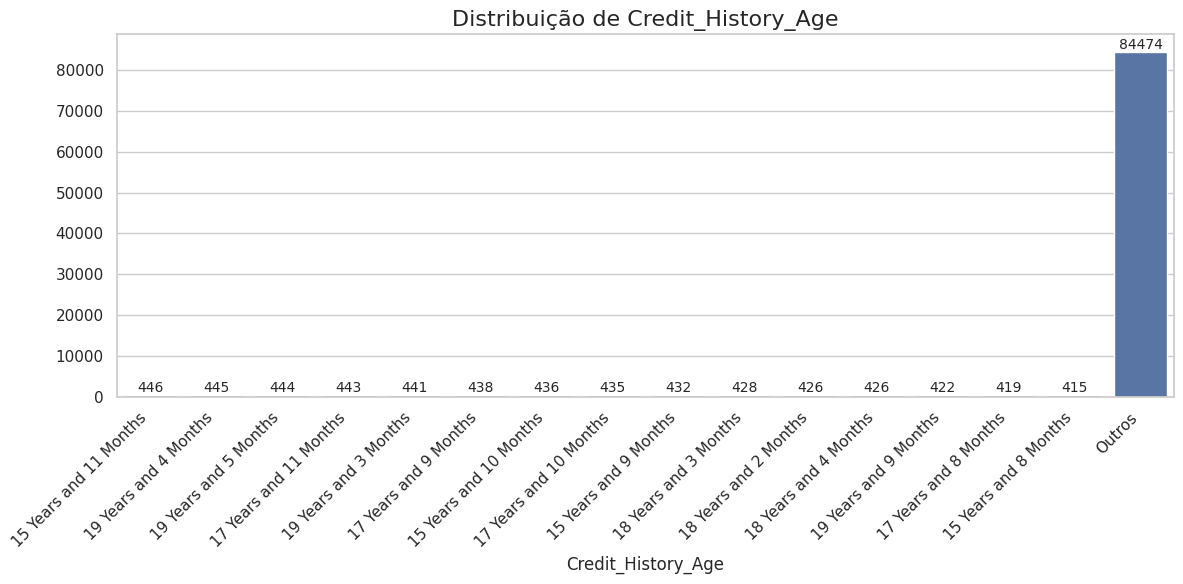


Valores únicos em Credit_History_Age:
Credit_History_Age
15 Years and 11 Months      446
19 Years and 4 Months       445
19 Years and 5 Months       444
17 Years and 11 Months      443
19 Years and 3 Months       441
17 Years and 9 Months       438
15 Years and 10 Months      436
17 Years and 10 Months      435
15 Years and 9 Months       432
18 Years and 3 Months       428
18 Years and 2 Months       426
18 Years and 4 Months       426
19 Years and 9 Months       422
17 Years and 8 Months       419
15 Years and 8 Months       415
Outros                    84474
Name: count, dtype: int64


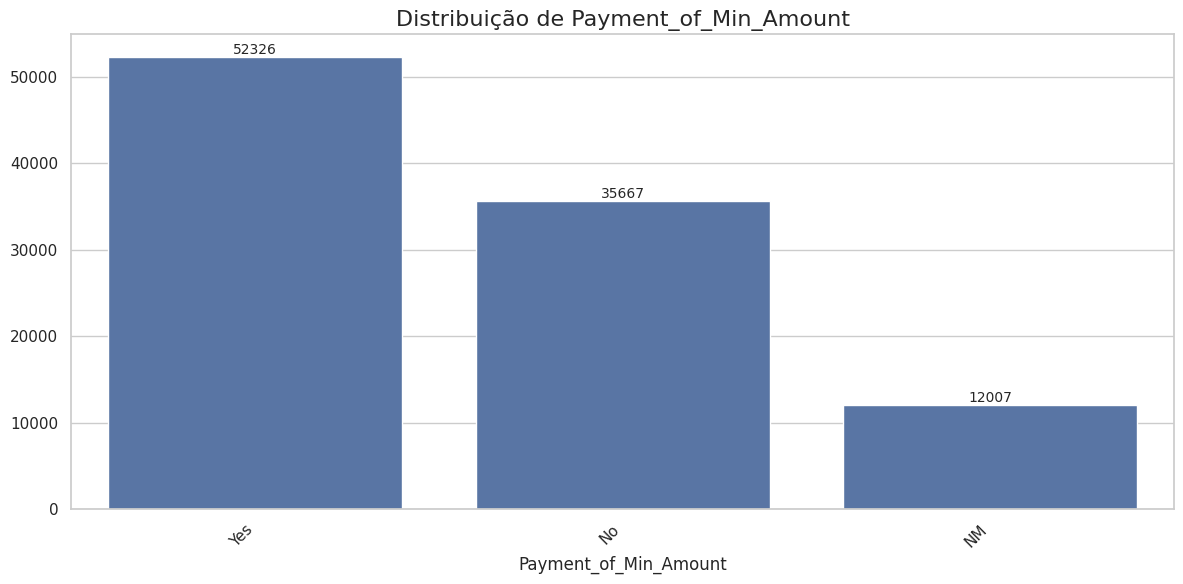


Valores únicos em Payment_of_Min_Amount:
Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64


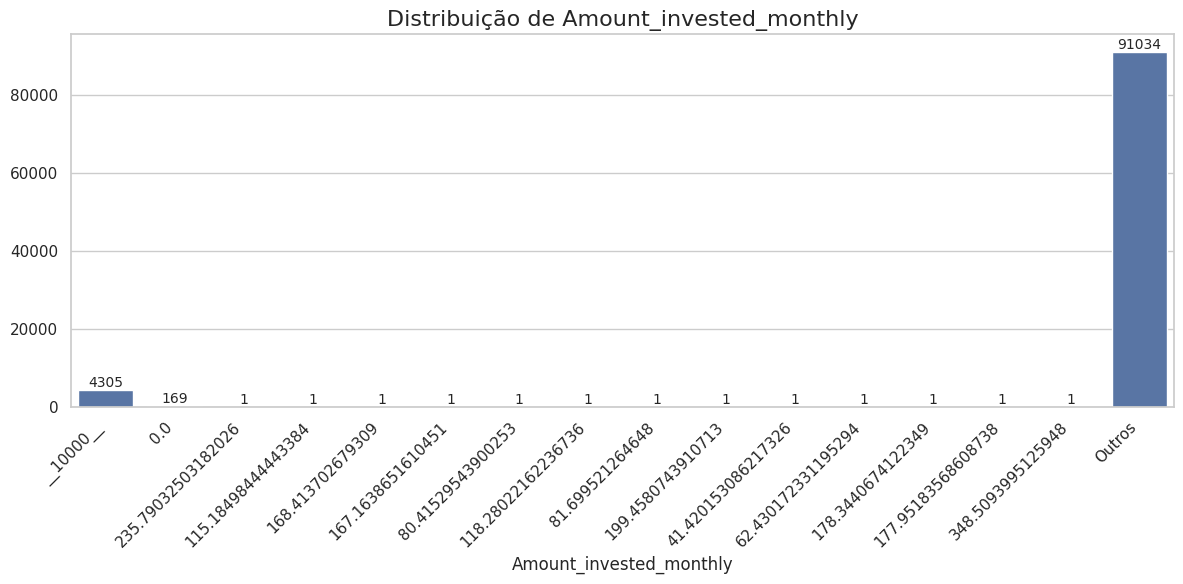


Valores únicos em Amount_invested_monthly:
Amount_invested_monthly
__10000__              4305
0.0                     169
235.79032503182026        1
115.18498444443384        1
168.413702679309          1
167.1638651610451         1
80.41529543900253         1
118.28022162236736        1
81.699521264648           1
199.4580743910713         1
41.420153086217326        1
62.430172331195294        1
178.3440674122349         1
177.95183568608738        1
348.5093995125948         1
Outros                91034
Name: count, dtype: int64


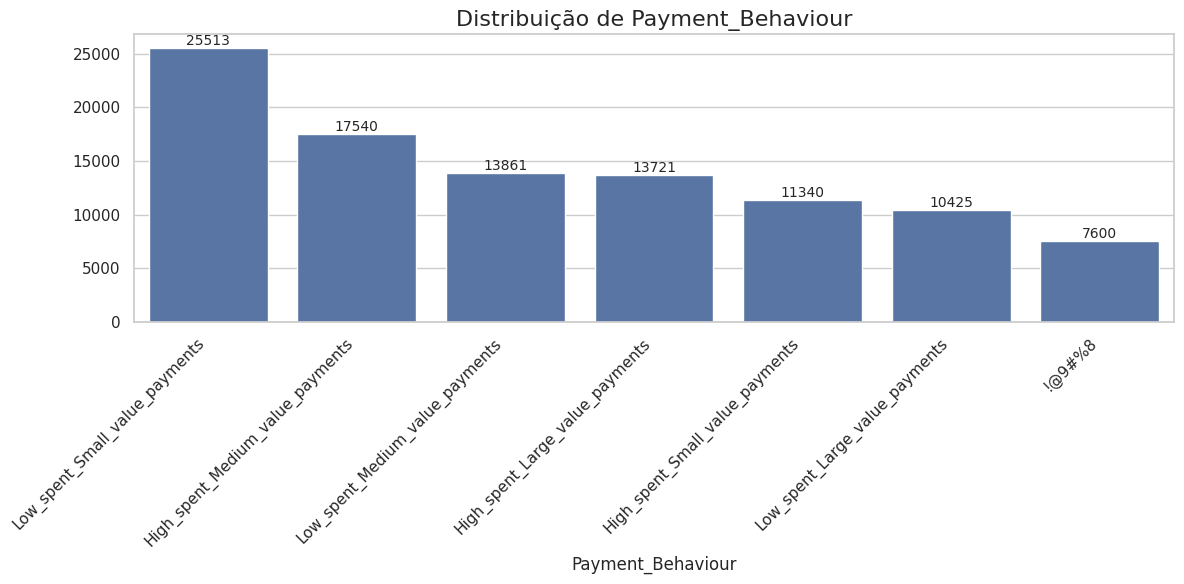


Valores únicos em Payment_Behaviour:
Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: count, dtype: int64


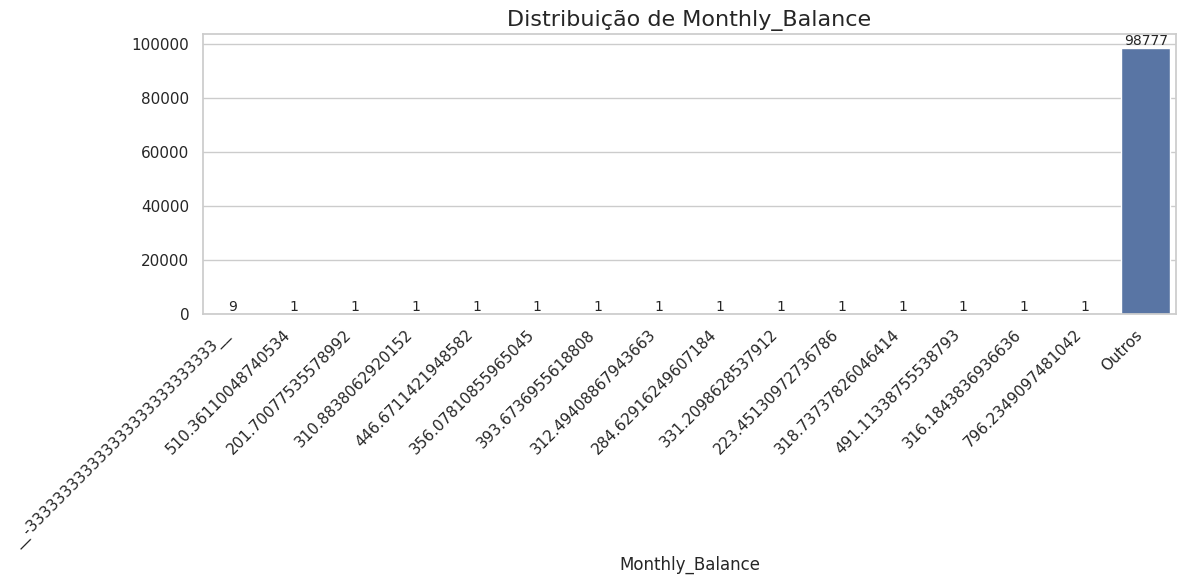


Valores únicos em Monthly_Balance:
Monthly_Balance
__-333333333333333333333333333__        9
510.36110048740534                      1
201.700775                              1
310.883806                              1
446.671142                              1
356.07810855965045                      1
393.673696                              1
312.49408867943663                      1
284.62916249607184                      1
331.2098628537912                       1
223.45130972736786                      1
318.737378                              1
491.11338755538793                      1
316.184384                              1
796.2349097481042                       1
Outros                              98777
Name: count, dtype: int64


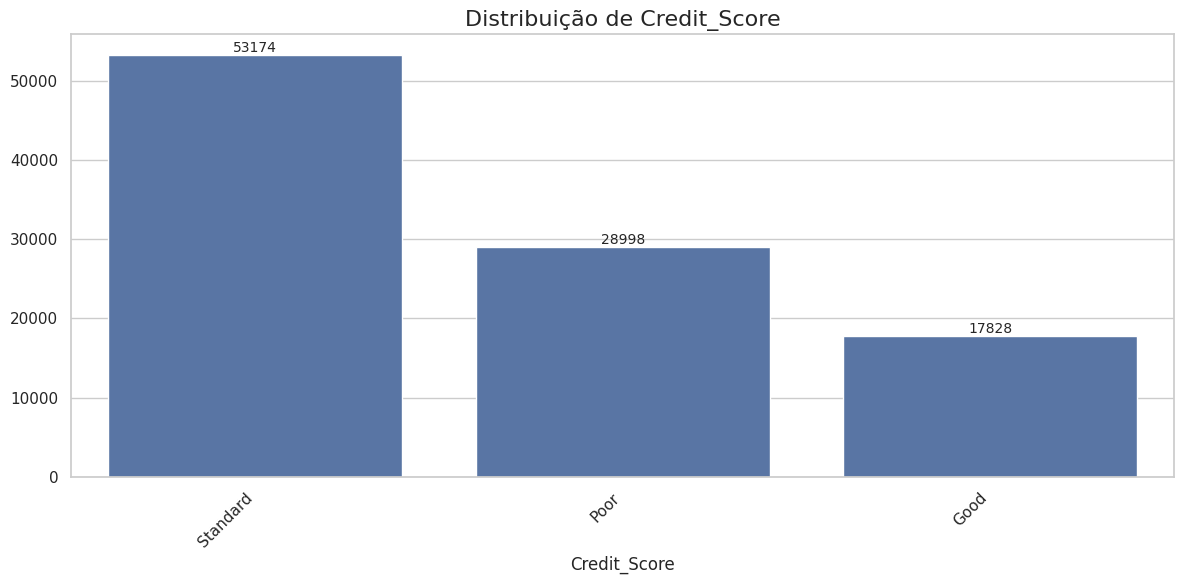


Valores únicos em Credit_Score:
Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64


In [14]:
# Identificando colunas categóricas
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['ID', 'Customer_ID', 'Name', 'SSN']]

print(f"Colunas categóricas: {categorical_cols}")

# Analisando a distribuição das variáveis categóricas
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    value_counts = train_df[col].value_counts().sort_values(ascending=False)

    # Limitando a 15 categorias para melhor visualização
    if len(value_counts) > 15:
        other_count = value_counts[15:].sum()
        value_counts = value_counts[:15]
        value_counts['Outros'] = other_count

    ax = sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Distribuição de {col}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Adicionar rótulos de contagem em cada barra
    for i, count in enumerate(value_counts.values):
        ax.text(i, count + 5, f'{count}', ha='center', va='bottom', fontsize=10)

    plt.show()

    # Mostrar os valores únicos e suas contagens
    print(f"\nValores únicos em {col}:")
    print(value_counts)

## 1.6 Relação entre Variáveis e a Variável Alvo

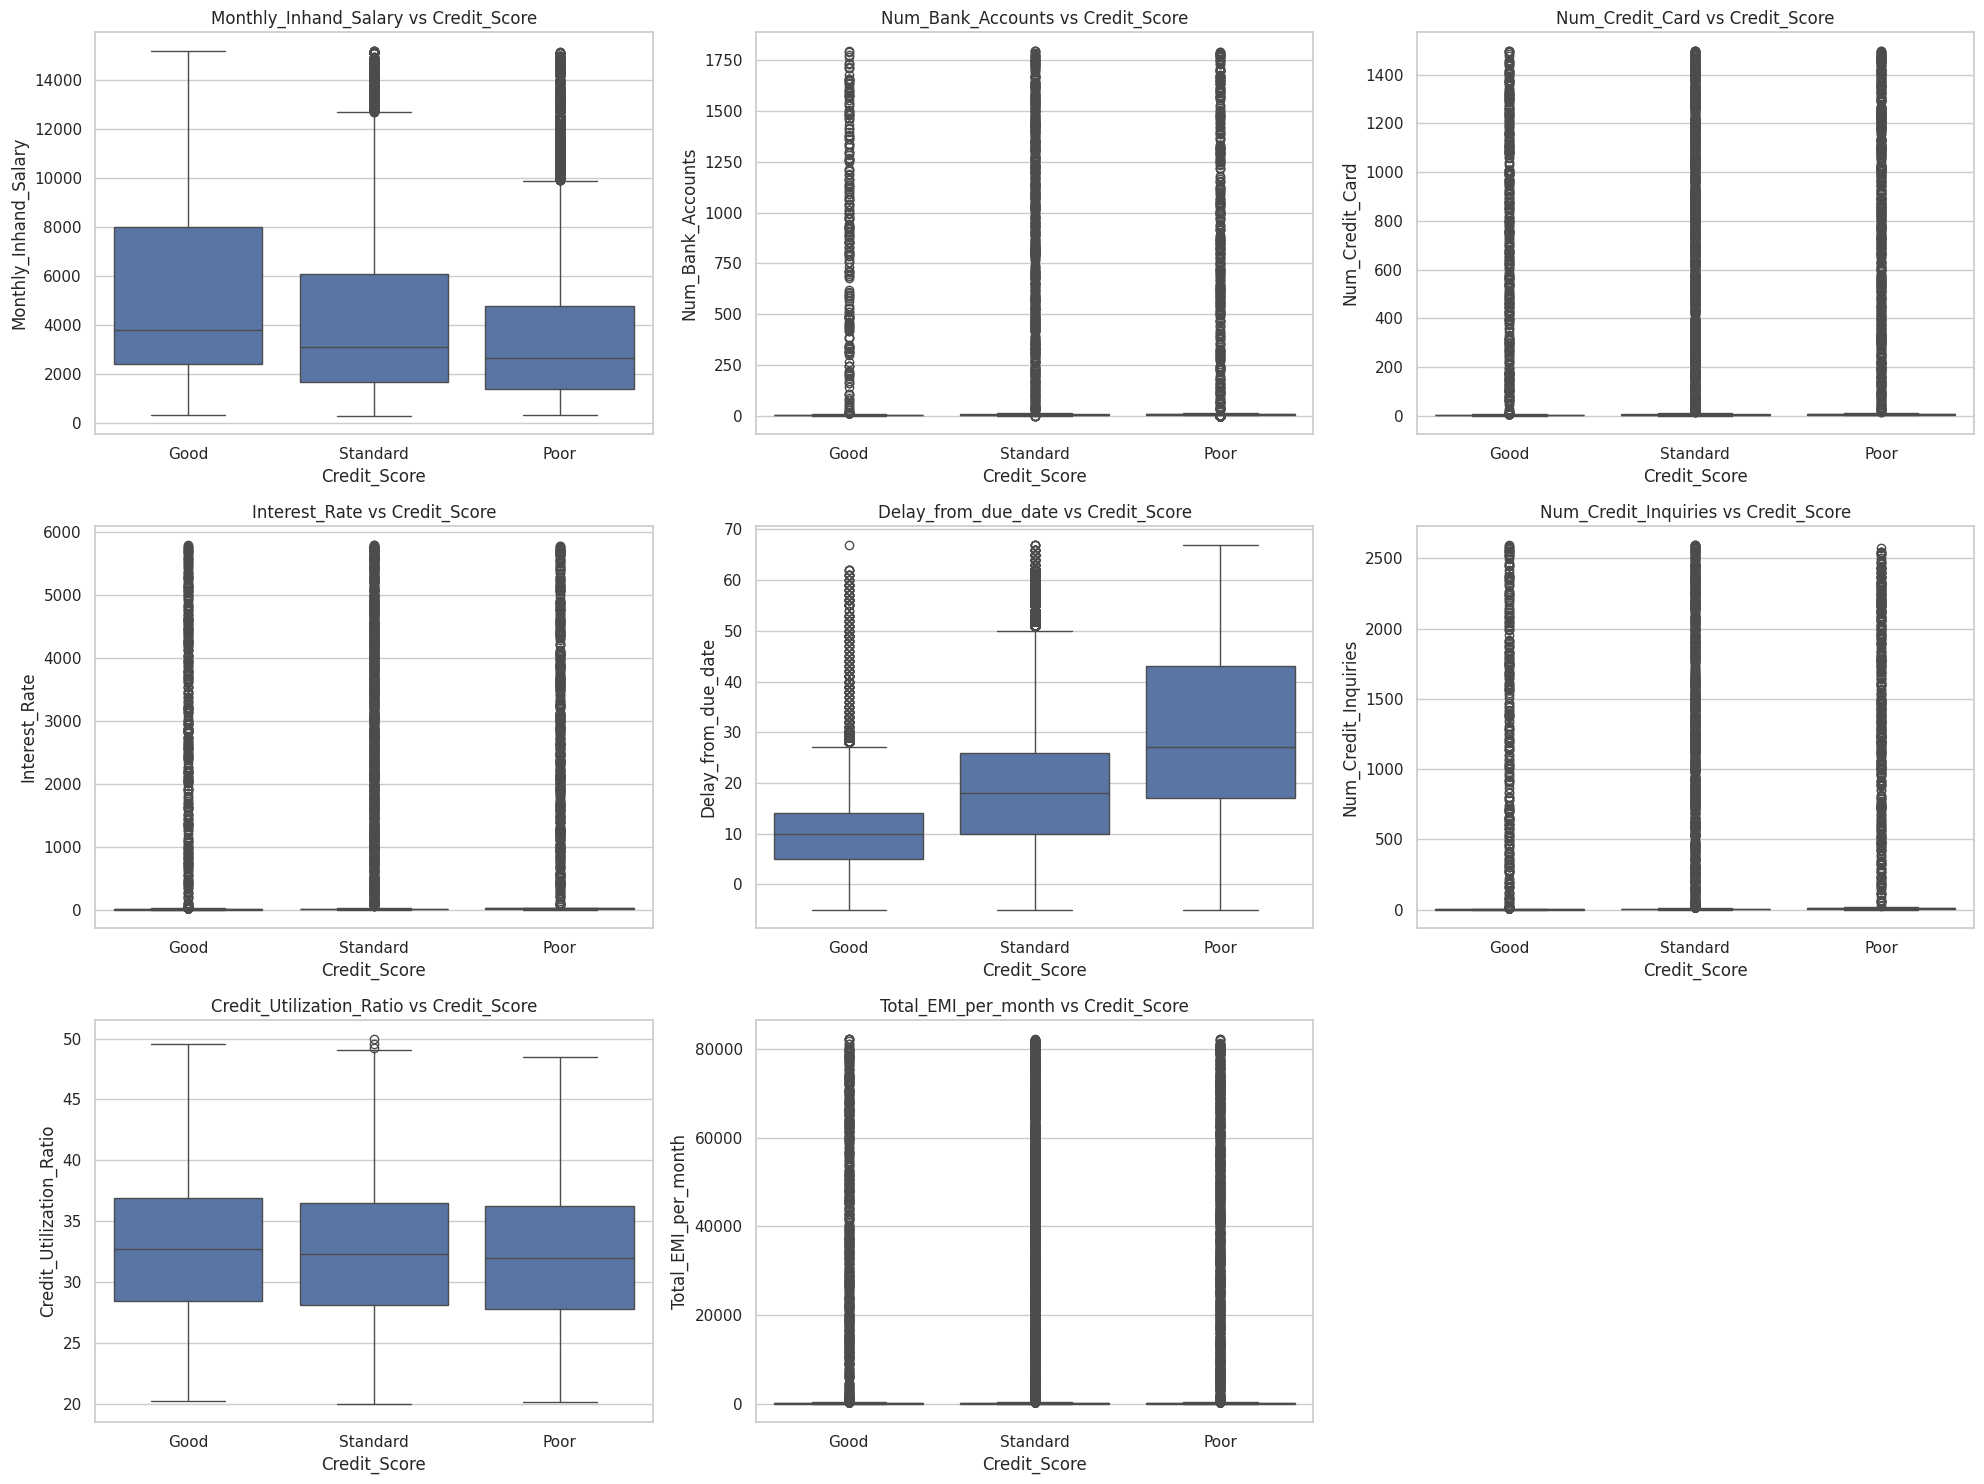

In [15]:
# Relação entre variáveis numéricas e a variável alvo
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols[:9], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Credit_Score', y=col, data=train_df)
    plt.title(f'{col} vs Credit_Score')
    plt.tight_layout()
plt.show()

if len(numeric_cols) > 9:
    plt.figure(figsize=(20, 15))
    for i, col in enumerate(numeric_cols[9:18], 1):
        plt.subplot(3, 3, i)
        sns.boxplot(x='Credit_Score', y=col, data=train_df)
        plt.title(f'{col} vs Credit_Score')
        plt.tight_layout()
    plt.show()

if len(numeric_cols) > 18:
    plt.figure(figsize=(20, 15))
    for i, col in enumerate(numeric_cols[18:], 1):
        plt.subplot(3, 3, i)
        sns.boxplot(x='Credit_Score', y=col, data=train_df)
        plt.title(f'{col} vs Credit_Score')
        plt.tight_layout()
    plt.show()

<Figure size 1400x800 with 0 Axes>

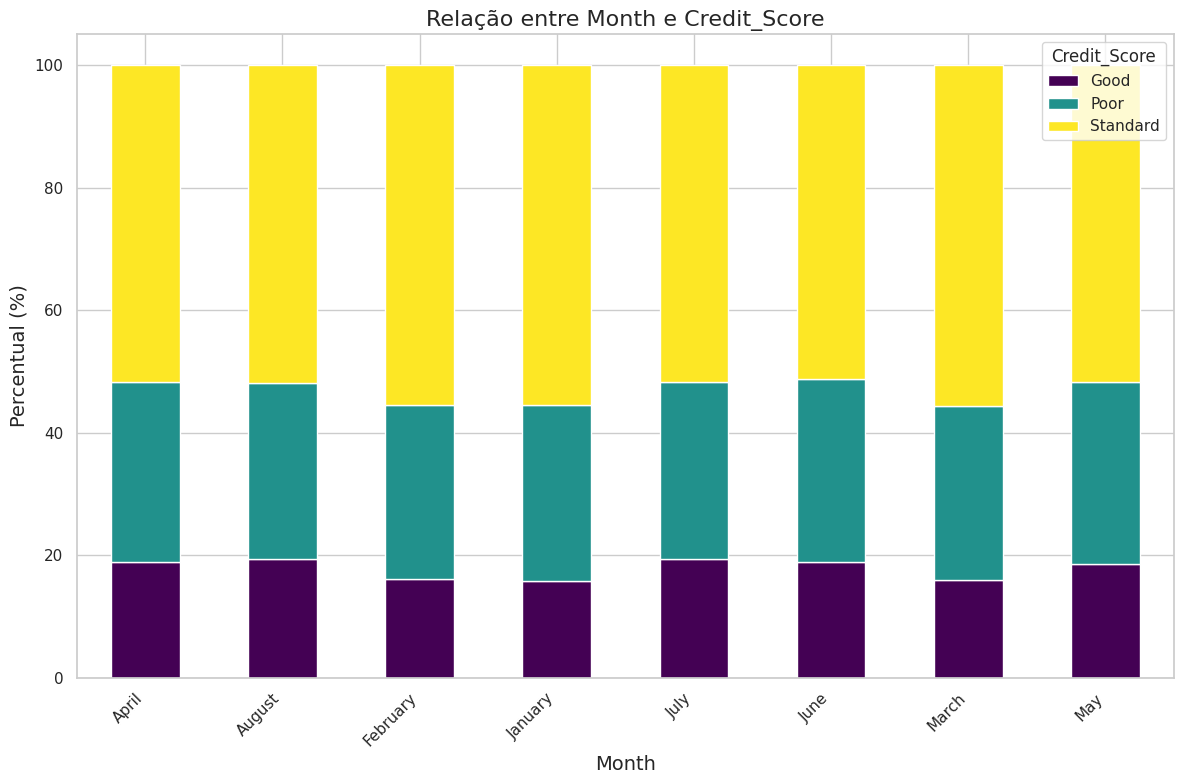

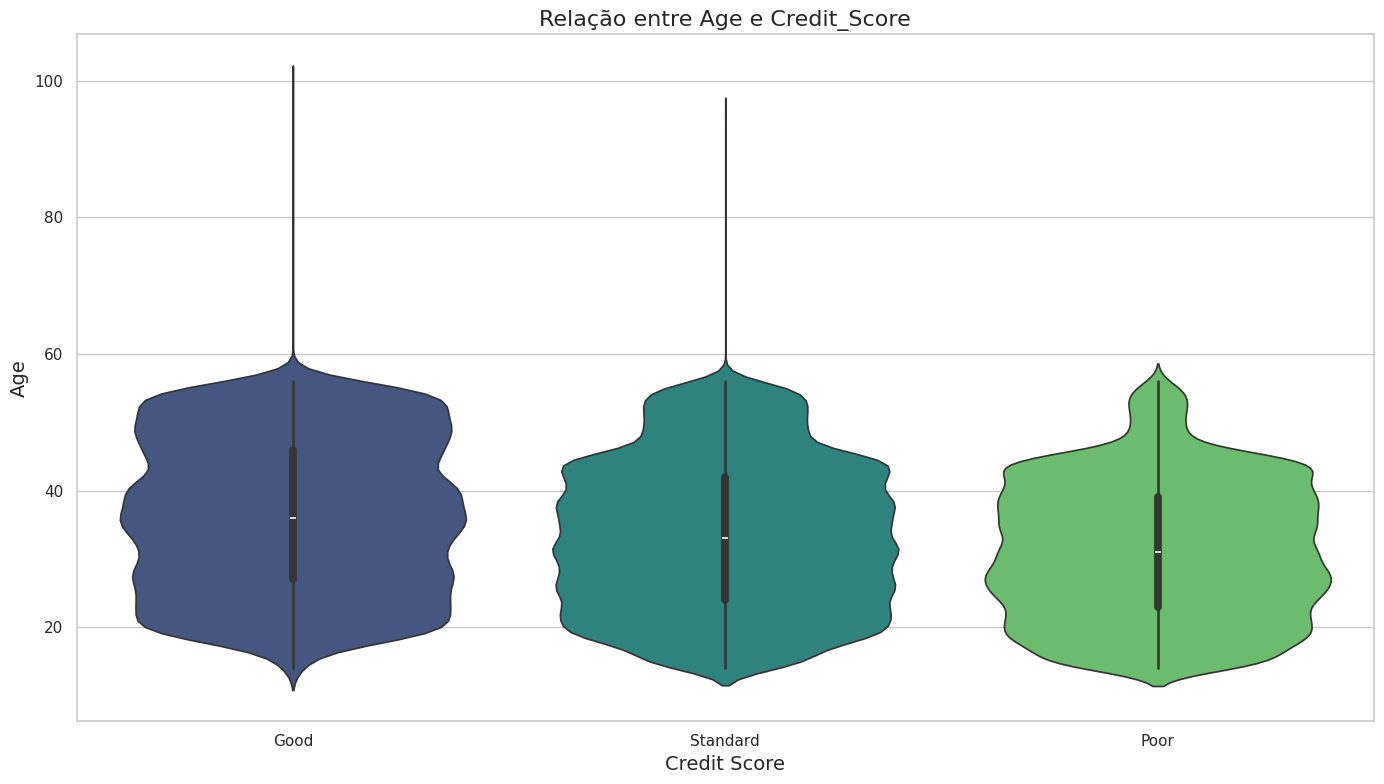

<Figure size 1400x800 with 0 Axes>

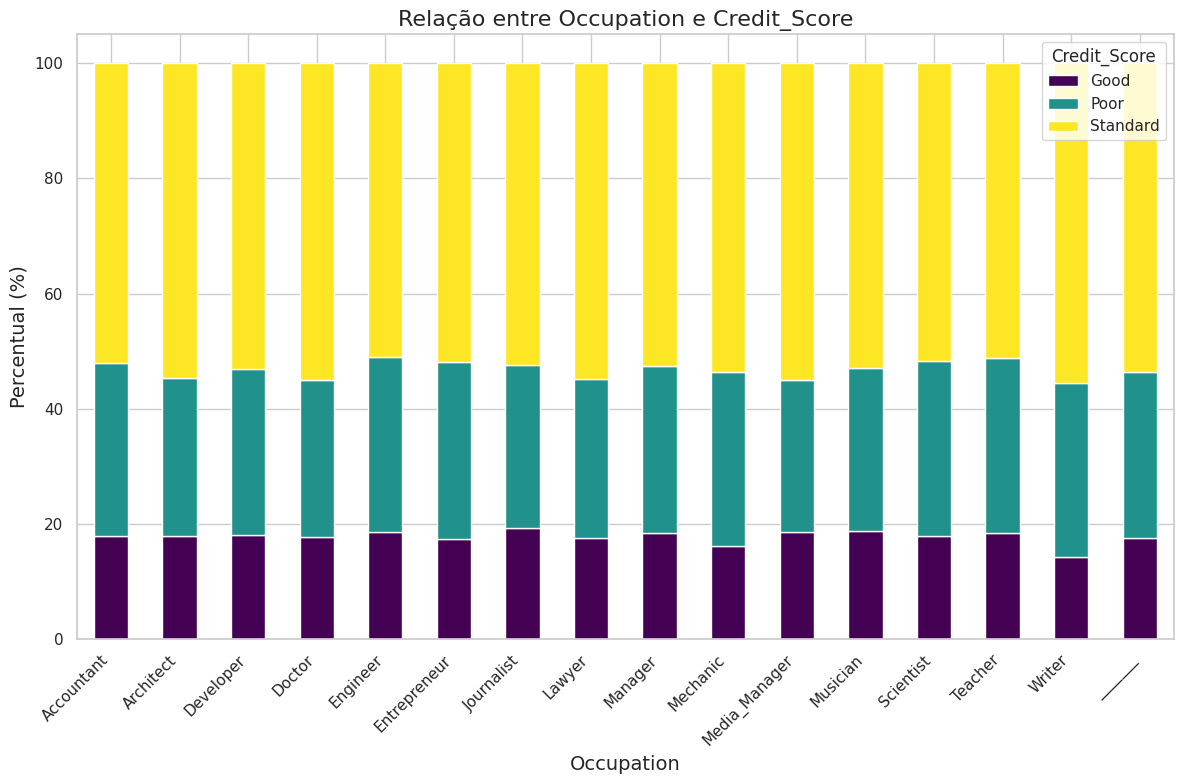

In [16]:
# Relação entre variáveis categóricas e a variável alvo
for col in categorical_cols[:3]:  # Limitando a 3 variáveis categóricas para melhor visualização
    plt.figure(figsize=(14, 8))

    # Verificar se a coluna é 'Age' (que deveria ser numérica, não categórica)
    if col == 'Age':
        # Para Age, usamos uma abordagem diferente
        age_data = train_df.copy()
        # Primeiro convertemos para numérico, tratando erros
        age_data['Age'] = pd.to_numeric(age_data['Age'], errors='coerce')
        # Removendo valores negativos ou extremamente altos na idade
        age_data = age_data[(age_data['Age'] > 0) & (age_data['Age'] < 100)]

        # Usando violinplot para idade
        sns.violinplot(x='Credit_Score', y='Age', data=age_data, palette='viridis')
        plt.title(f'Relação entre {col} e Credit_Score', fontsize=16)
        plt.xlabel('Credit Score', fontsize=14)
        plt.ylabel('Age', fontsize=14)
    else:
        # Para outras variáveis categóricas, mantemos o código original
        # Criando uma tabela de contingência
        cross_tab = pd.crosstab(train_df[col], train_df['Credit_Score'], normalize='index') * 100

        # Plotando o gráfico de barras empilhadas
        cross_tab.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title(f'Relação entre {col} e Credit_Score', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Percentual (%)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Credit_Score')

    plt.tight_layout()
    plt.show()


## 1.7 Matriz de Correlação

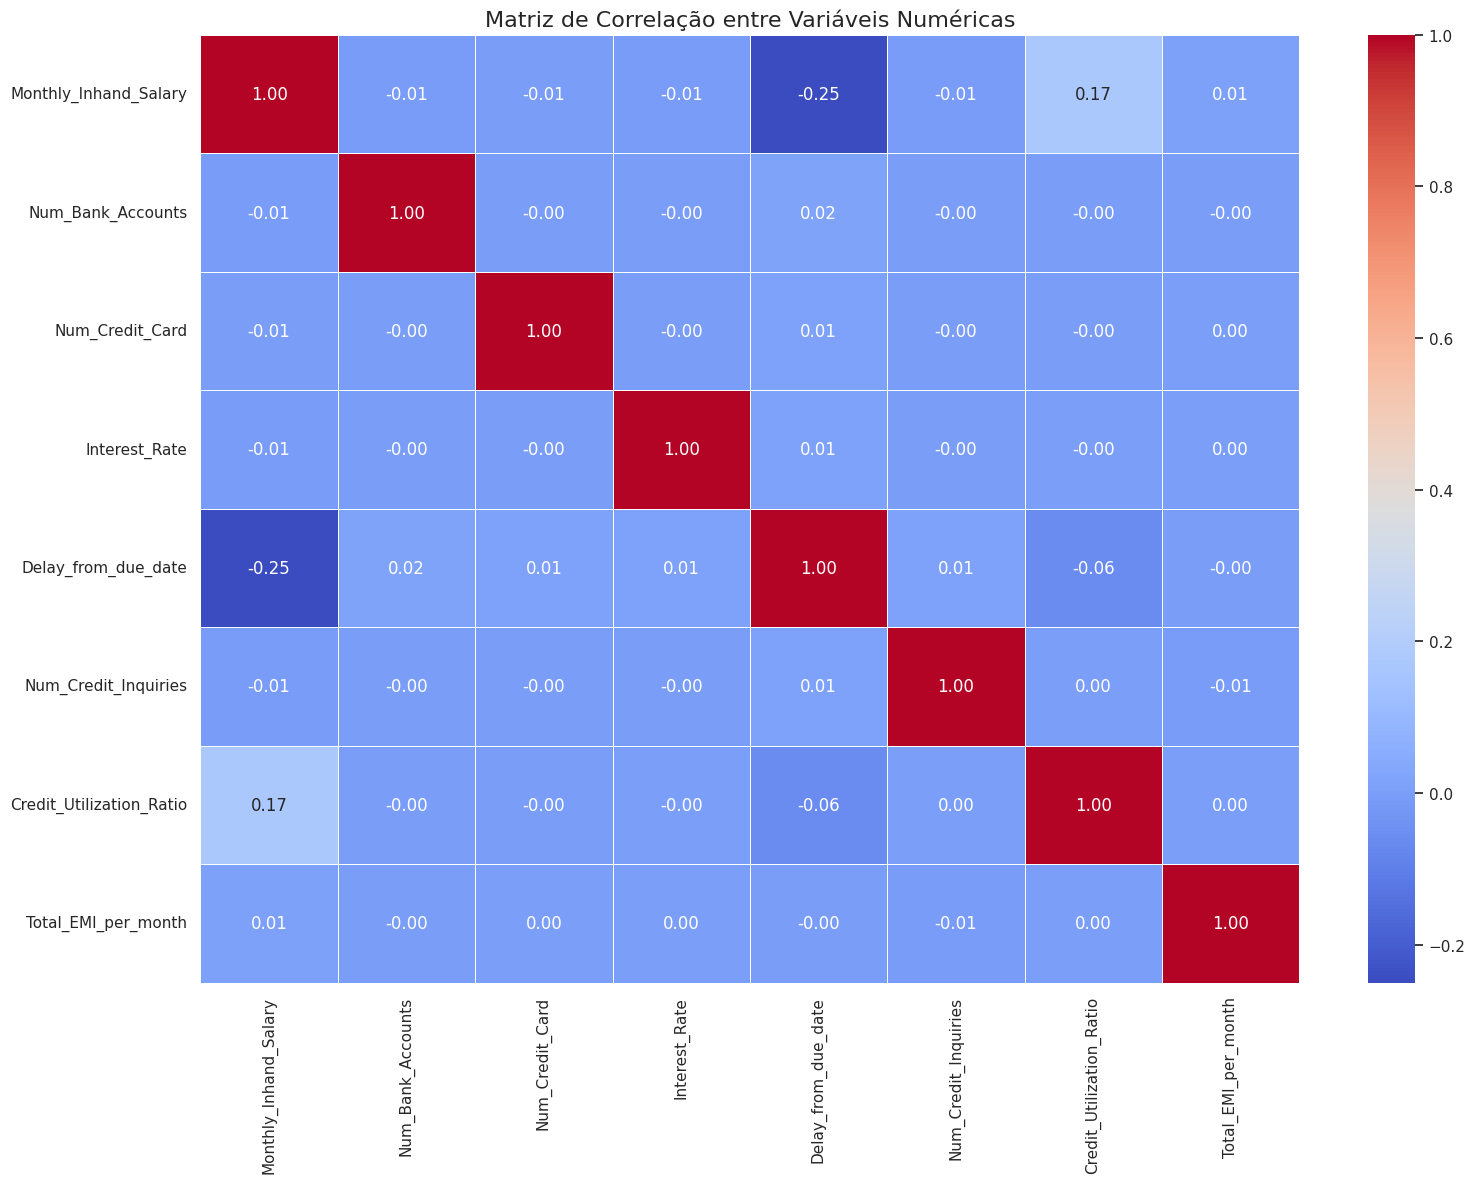

In [17]:
# Calculando a matriz de correlação para variáveis numéricas
correlation_matrix = train_df[numeric_cols].corr()

# Plotando o mapa de calor da matriz de correlação
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

## 1.8 Verificação de Inconsistências nos Dados

In [18]:
# Verificando valores inconsistentes em colunas numéricas
for col in numeric_cols:
    # Verificando valores negativos onde não faz sentido
    if col in ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
               'Interest_Rate', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries',
               'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
               'Amount_invested_monthly', 'Monthly_Balance']:
        neg_count = (train_df[col] < 0).sum()
        if neg_count > 0:
            print(f"Coluna {col} tem {neg_count} valores negativos.")

    # Verificando valores extremamente altos (potenciais outliers)
    q3 = train_df[col].quantile(0.75)
    iqr = train_df[col].quantile(0.75) - train_df[col].quantile(0.25)
    upper_bound = q3 + 3 * iqr  # Usando 3*IQR como limite para outliers extremos
    extreme_count = (train_df[col] > upper_bound).sum()
    if extreme_count > 0:
        print(f"Coluna {col} tem {extreme_count} valores extremamente altos (> Q3 + 3*IQR).")

# Verificando valores inconsistentes em colunas categóricas
for col in categorical_cols:
    # Verificando valores estranhos ou inconsistentes
    unusual_values = [val for val in train_df[col].unique() if isinstance(val, str) and any(c in val for c in ['!', '@', '#', '$', '%', '&', '*'])]
    if unusual_values:
        print(f"Coluna {col} tem valores incomuns: {unusual_values}")

Coluna Num_Bank_Accounts tem 21 valores negativos.
Coluna Num_Bank_Accounts tem 1314 valores extremamente altos (> Q3 + 3*IQR).
Coluna Num_Credit_Card tem 2266 valores extremamente altos (> Q3 + 3*IQR).
Coluna Interest_Rate tem 2034 valores extremamente altos (> Q3 + 3*IQR).
Coluna Num_Credit_Inquiries tem 1649 valores extremamente altos (> Q3 + 3*IQR).
Coluna Total_EMI_per_month tem 4270 valores extremamente altos (> Q3 + 3*IQR).
Coluna Payment_Behaviour tem valores incomuns: ['!@9#%8']


## 1.9 Insights da Análise Exploratória

Com base na análise exploratória realizada, podemos destacar os seguintes insights:

1. **Distribuição da Variável Alvo**: A variável Credit_Score apresenta três categorias: 'Good', 'Standard' e 'Poor'. É importante entender a proporção de cada categoria para avaliar se há desbalanceamento nos dados.

2. **Valores Ausentes e Inconsistentes**: Identificamos valores ausentes representados por NaN, bem como valores especiais como '_', 'NA', '!@9#%8' que também podem representar dados faltantes. Esses valores precisarão ser tratados adequadamente.

3. **Outliers**: Algumas variáveis numéricas apresentam outliers significativos, como visto nos boxplots. Esses outliers podem afetar o desempenho dos modelos e precisam ser considerados durante o pré-processamento.

4. **Correlações**: A matriz de correlação mostra relações importantes entre variáveis numéricas. Variáveis altamente correlacionadas podem indicar multicolinearidade, o que pode afetar alguns modelos.

5. **Relações com a Variável Alvo**: Identificamos variáveis que parecem ter forte relação com o Credit_Score, o que pode ser útil para a seleção de features importantes para os modelos.

6. **Inconsistências nos Dados**: Encontramos valores inconsistentes, como idades negativas e caracteres especiais em campos que deveriam ser numéricos ou categóricos bem definidos.

Esses insights serão fundamentais para guiar as etapas de pré-processamento e modelagem.

# 2. Preparação dos Dados para Modelagem

Com base na análise exploratória, vamos preparar os dados para a modelagem, tratando valores ausentes, inconsistências e realizando as transformações necessárias.

In [19]:
# Criando cópias dos dataframes para não modificar os originais
train_prep = train_df.copy()
test_prep = test_df.copy()

## 2.1 Tratamento de Valores Ausentes e Inconsistentes

In [20]:
# Função para tratar valores especiais como NaN
def treat_special_values(df, special_values=['_', 'NA', '!@9#%8', '#F%$D@*&8']):
    df_copy = df.copy()
    for col in df_copy.columns:
        for val in special_values:
            df_copy[col] = df_copy[col].replace(val, np.nan)
    return df_copy

# Aplicando o tratamento de valores especiais
train_prep = treat_special_values(train_prep)
test_prep = treat_special_values(test_prep)

# Verificando valores ausentes após o tratamento
missing_train_after = train_prep.isnull().sum()
missing_train_percent_after = (missing_train_after / len(train_prep)) * 100
missing_train_df_after = pd.DataFrame({'Contagem': missing_train_after, 'Percentual (%)': missing_train_percent_after})
missing_train_df_after = missing_train_df_after[missing_train_df_after['Contagem'] > 0].sort_values('Percentual (%)', ascending=False)

print("Valores ausentes no conjunto de treino após tratamento:")
display(missing_train_df_after)

Valores ausentes no conjunto de treino após tratamento:


,Contagem,Percentual (%)
Credit_Mix,20195,20.195
Monthly_Inhand_Salary,15002,15.002
Type_of_Loan,11408,11.408
Name,9985,9.985
Credit_History_Age,9030,9.030
Payment_Behaviour,7600,7.600
Num_of_Delayed_Payment,7002,7.002
SSN,5572,5.572
Amount_invested_monthly,4479,4.479
Changed_Credit_Limit,2091,2.091


In [21]:
# Tratando valores inconsistentes em colunas específicas

# Tratando a coluna Age - removendo sufixos como '_' e convertendo para numérico
train_prep['Age'] = train_prep['Age'].astype(str).str.replace('_', '').replace('', np.nan).astype(float)
test_prep['Age'] = test_prep['Age'].astype(str).str.replace('_', '').replace('', np.nan).astype(float)

# Tratando valores negativos em Age (não faz sentido idade negativa)
train_prep.loc[train_prep['Age'] < 0, 'Age'] = np.nan
test_prep.loc[test_prep['Age'] < 0, 'Age'] = np.nan

# Tratando a coluna Credit_History_Age - extraindo apenas os valores numéricos
def extract_years_months(age_str):
    if pd.isna(age_str) or age_str == 'NA':
        return np.nan
    try:
        if 'Years' in str(age_str) and 'Months' in str(age_str):
            years = int(str(age_str).split('Years')[0].strip())
            months = int(str(age_str).split('and')[1].split('Months')[0].strip())
            return years + months/12
        else:
            return np.nan
    except:
        return np.nan

train_prep['Credit_History_Age_Years'] = train_prep['Credit_History_Age'].apply(extract_years_months)
test_prep['Credit_History_Age_Years'] = test_prep['Credit_History_Age'].apply(extract_years_months)

# Tratando a coluna Num_of_Delayed_Payment - removendo sufixos como '_'
train_prep['Num_of_Delayed_Payment'] = train_prep['Num_of_Delayed_Payment'].astype(str).str.replace('_', '').replace('', np.nan).astype(float)
test_prep['Num_of_Delayed_Payment'] = test_prep['Num_of_Delayed_Payment'].astype(str).str.replace('_', '').replace('', np.nan).astype(float)

# Tratando a coluna Changed_Credit_Limit
train_prep['Changed_Credit_Limit'] = pd.to_numeric(train_prep['Changed_Credit_Limit'], errors='coerce')
test_prep['Changed_Credit_Limit'] = pd.to_numeric(test_prep['Changed_Credit_Limit'], errors='coerce')

# Tratando a coluna Num_Credit_Inquiries
train_prep['Num_Credit_Inquiries'] = pd.to_numeric(train_prep['Num_Credit_Inquiries'], errors='coerce')
test_prep['Num_Credit_Inquiries'] = pd.to_numeric(test_prep['Num_Credit_Inquiries'], errors='coerce')

# Verificando os resultados após o tratamento
print("\nEstatísticas das colunas após tratamento:")
for col in ['Age', 'Credit_History_Age_Years', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries']:
    if col in train_prep.columns:
        print(f"\n{col}:")
        print(train_prep[col].describe())


Estatísticas das colunas após tratamento:

Age:
count    99114.000000
mean       116.108421
std        686.861274
min         14.000000
25%         25.000000
50%         33.000000
75%         42.000000
max       8698.000000
Name: Age, dtype: float64

Credit_History_Age_Years:
count    90970.000000
mean        18.432950
std          8.311780
min          0.083333
25%         12.000000
50%         18.250000
75%         25.166667
max         33.666667
Name: Credit_History_Age_Years, dtype: float64

Num_of_Delayed_Payment:
count    92998.000000
mean        30.923342
std        226.031892
min         -3.000000
25%          9.000000
50%         14.000000
75%         18.000000
max       4397.000000
Name: Num_of_Delayed_Payment, dtype: float64

Changed_Credit_Limit:
count    97909.000000
mean        10.389025
std          6.789496
min         -6.490000
25%          5.320000
50%          9.400000
75%         14.870000
max         36.970000
Name: Changed_Credit_Limit, dtype: float64

Num_Credit

## 2.2 Seleção de Features

In [22]:
# Removendo colunas que não serão utilizadas na modelagem
cols_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN', 'Credit_History_Age']
train_prep = train_prep.drop(cols_to_drop, axis=1)
test_prep = test_prep.drop(cols_to_drop, axis=1)

# Separando features e target no conjunto de treino
X_train = train_prep.drop('Credit_Score', axis=1)
y_train = train_prep['Credit_Score']

# Conjunto de teste (sem a variável alvo)
X_test = test_prep.copy()

# Verificando as dimensões após a seleção de features
print(f"Dimensões de X_train: {X_train.shape}")
print(f"Dimensões de y_train: {y_train.shape}")
print(f"Dimensões de X_test: {X_test.shape}")

Dimensões de X_train: (100000, 23)
Dimensões de y_train: (100000,)
Dimensões de X_test: (50000, 23)


## 2.3 Divisão em Conjuntos de Treino e Validação

In [23]:
# Dividindo o conjunto de treino em treino e validação
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Verificando as dimensões após a divisão
print(f"Dimensões de X_train_split: {X_train_split.shape}")
print(f"Dimensões de y_train_split: {y_train_split.shape}")
print(f"Dimensões de X_val: {X_val.shape}")
print(f"Dimensões de y_val: {y_val.shape}")

# Verificando a distribuição da variável alvo nos conjuntos de treino e validação
print("\nDistribuição da variável alvo no conjunto de treino original:")
print(y_train.value_counts(normalize=True) * 100)

print("\nDistribuição da variável alvo no conjunto de treino após divisão:")
print(y_train_split.value_counts(normalize=True) * 100)

print("\nDistribuição da variável alvo no conjunto de validação:")
print(y_val.value_counts(normalize=True) * 100)

Dimensões de X_train_split: (80000, 23)
Dimensões de y_train_split: (80000,)
Dimensões de X_val: (20000, 23)
Dimensões de y_val: (20000,)

Distribuição da variável alvo no conjunto de treino original:
Credit_Score
Standard    53.174
Poor        28.998
Good        17.828
Name: proportion, dtype: float64

Distribuição da variável alvo no conjunto de treino após divisão:
Credit_Score
Standard    53.17375
Poor        28.99875
Good        17.82750
Name: proportion, dtype: float64

Distribuição da variável alvo no conjunto de validação:
Credit_Score
Standard    53.175
Poor        28.995
Good        17.830
Name: proportion, dtype: float64


## 2.4 Identificação de Tipos de Colunas para Pré-processamento

In [24]:
# Identificando colunas numéricas e categóricas para o pré-processamento
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Features numéricas ({len(numeric_features)}): {numeric_features}")
print(f"Features categóricas ({len(categorical_features)}): {categorical_features}")

Features numéricas (12): ['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Credit_History_Age_Years']
Features categóricas (11): ['Month', 'Occupation', 'Annual_Income', 'Num_of_Loan', 'Type_of_Loan', 'Credit_Mix', 'Outstanding_Debt', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance']


# 3. Implementação do Pipeline de Classificação

Vamos implementar um pipeline de classificação usando Random Forest, XGBoost e LightGBM, com GridSearch para otimização de parâmetros.

## 3.1 Definição do Pré-processamento

In [25]:
# Garantir que todas as colunas categóricas sejam strings e tratar valores ausentes
for col in categorical_features:
    X_train_split[col] = X_train_split[col].astype(str).replace('nan', 'missing')
    X_val[col] = X_val[col].astype(str).replace('nan', 'missing')


# Definindo o pré-processamento para features numéricas e categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinando os transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Codificando a variável alvo
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_split)
y_val_encoded = label_encoder.transform(y_val)

# Verificando o mapeamento da codificação
print("Mapeamento da codificação da variável alvo:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

Mapeamento da codificação da variável alvo:
Good -> 0
Poor -> 1
Standard -> 2


## 3.2 Pipeline com Random Forest

In [26]:
# Definindo o pipeline para Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parâmetros mais equilibrados para GridSearch
rf_param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1]
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Treinando o modelo
print("Treinando o modelo Random Forest com GridSearch...")
rf_grid_search.fit(X_train_split, y_train_split)

# Melhores parâmetros encontrados
print("\nMelhores parâmetros para Random Forest:")
print(rf_grid_search.best_params_)

# Melhor score
print(f"\nMelhor F1 ponderado (CV): {rf_grid_search.best_score_:.4f}")

# Avaliando no conjunto de validação
rf_best = rf_grid_search.best_estimator_
rf_val_pred = rf_best.predict(X_val)
rf_val_score = f1_score(y_val, rf_val_pred, average='weighted')
print(f"F1 ponderado no conjunto de validação: {rf_val_score:.4f}")

# Relatório de classificação detalhado
print("\nRelatório de classificação para Random Forest no conjunto de validação:")
print(classification_report(y_val, rf_val_pred))


Treinando o modelo Random Forest com GridSearch...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Melhores parâmetros para Random Forest:
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Melhor F1 ponderado (CV): 0.3692
F1 ponderado no conjunto de validação: 0.3692

Relatório de classificação para Random Forest no conjunto de validação:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00      3566
        Poor       0.00      0.00      0.00      5799
    Standard       0.53      1.00      0.69     10635

    accuracy                           0.53     20000
   macro avg       0.18      0.33      0.23     20000
weighted avg       0.28      0.53      0.37     20000



## 3.3 Pipeline com XGBoost

In [27]:
# Cache pré-processamento
cache_dir = os.path.join(tempfile.gettempdir(), 'xgb_cache')
os.makedirs(cache_dir, exist_ok=True)
memory = Memory(location=cache_dir, verbose=0)

# Classificador otimizado pra GPU
xgb_classifier = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='gpu_hist', # Usar GPU
    verbosity=0  # Reduzir logs
)

xgb_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_classifier)
    ],
    memory=memory
)

# Parâmetros para GridSearch
xgb_param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10],
    'classifier__learning_rate': [0.1],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8]
}

# GridSearch com validação cruzada reduzida
xgb_grid_search = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,  # Mesmo valor usado no RF
    scoring='f1_weighted',
    n_jobs=-1,
    pre_dispatch='n_jobs',
    verbose=1
)

# Importante: Codificar a variável alvo para valores numéricos
# Isso já foi feito anteriormente, mas vamos garantir que estamos usando os valores codificados
if 'label_encoder' not in locals() or 'y_train_encoded' not in locals():
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_split)
    y_val_encoded = label_encoder.transform(y_val)

# Treinando o modelo com os valores codificados
print("Treinando o modelo XGBoost com GridSearch...")
xgb_grid_search.fit(X_train_split, y_train_encoded)

# Melhores parâmetros encontrados
print("\nMelhores parâmetros para XGBoost:")
print(xgb_grid_search.best_params_)

# Melhor score
print(f"\nMelhor F1 ponderado (CV): {xgb_grid_search.best_score_:.4f}")

# Avaliando no conjunto de validação
xgb_best = xgb_grid_search.best_estimator_
xgb_val_pred = xgb_best.predict(X_val)
xgb_val_score = f1_score(y_val_encoded, xgb_val_pred, average='weighted')
print(f"F1 ponderado no conjunto de validação: {xgb_val_score:.4f}")

# Para obter as classes originais nas previsões
xgb_val_pred_classes = label_encoder.inverse_transform(xgb_val_pred)

# Relatório de classificação detalhado (usando as classes originais para melhor interpretação)
print("\nRelatório de classificação para XGBoost no conjunto de validação:")
print(classification_report(y_val, xgb_val_pred_classes))

Treinando o modelo XGBoost com GridSearch...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Melhores parâmetros para XGBoost:
{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

Melhor F1 ponderado (CV): 0.7308
F1 ponderado no conjunto de validação: 0.7344

Relatório de classificação para XGBoost no conjunto de validação:
              precision    recall  f1-score   support

        Good       0.63      0.70      0.66      3566
        Poor       0.76      0.67      0.71      5799
    Standard       0.76      0.78      0.77     10635

    accuracy                           0.73     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.74      0.73      0.73     20000



## 3.4 Pipeline com LightGBM




In [28]:
# Cache otimizado
cache_dir = os.path.join(tempfile.gettempdir(), 'lgbm_cache')
os.makedirs(cache_dir, exist_ok=True)
memory = Memory(location=cache_dir, verbose=0)

# Definindo o pipeline para LightGBM
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        device='gpu',  # Usar GPU
        verbosity=-1,  # Silenciar warnings
        force_col_wise=True,
        objective='multiclass',
        boosting_type='gbdt'
    ))
], memory=memory)

# Parâmetros para GridSearch
lgbm_param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10],
    'classifier__learning_rate': [0.1],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8]
}

# GridSearch com validação cruzada reduzida
lgbm_grid_search = GridSearchCV(
    lgbm_pipeline,
    lgbm_param_grid,
    cv=3,  # Mesmo valor usado no RF
    scoring='f1_weighted',
    n_jobs=-1,
    pre_dispatch='n_jobs',
    verbose=1
)

# Treinando o modelo com os valores codificados
print("Treinando o modelo LightGBM com GridSearch...")
lgbm_grid_search.fit(X_train_split, y_train_encoded)

# Melhores parâmetros encontrados
print("\nMelhores parâmetros para LightGBM:")
print(lgbm_grid_search.best_params_)

# Melhor score
print(f"\nMelhor F1 ponderado (CV): {lgbm_grid_search.best_score_:.4f}")

# Avaliando no conjunto de validação
lgbm_best = lgbm_grid_search.best_estimator_
lgbm_val_pred = lgbm_best.predict(X_val)
lgbm_val_score = f1_score(y_val_encoded, lgbm_val_pred, average='weighted')
print(f"F1 ponderado no conjunto de validação: {lgbm_val_score:.4f}")

# Para obter as classes originais nas previsões
lgbm_val_pred_classes = label_encoder.inverse_transform(lgbm_val_pred)

# Relatório de classificação detalhado (usando as classes originais para melhor interpretação)
print("\nRelatório de classificação para LightGBM no conjunto de validação:")
print(classification_report(y_val, lgbm_val_pred_classes))

Treinando o modelo LightGBM com GridSearch...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Melhores parâmetros para LightGBM:
{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

Melhor F1 ponderado (CV): 0.7166
F1 ponderado no conjunto de validação: 0.7169

Relatório de classificação para LightGBM no conjunto de validação:
              precision    recall  f1-score   support

        Good       0.60      0.69      0.64      3566
        Poor       0.74      0.65      0.69      5799
    Standard       0.75      0.76      0.76     10635

    accuracy                           0.72     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.72      0.72      0.72     20000



# 4. Avaliação dos Resultados

Vamos comparar os modelos e explicar por que escolhemos essa métrica pra avaliar o problema de score de crédito.

## 4.1 Comparação dos Modelos

Comparação dos modelos:


,Modelo,F1 Ponderado (CV),F1 Ponderado (Validação)
0,XGBoost,0.730764,0.734440
1,LightGBM,0.716591,0.716940
2,Random Forest,0.369182,0.369196


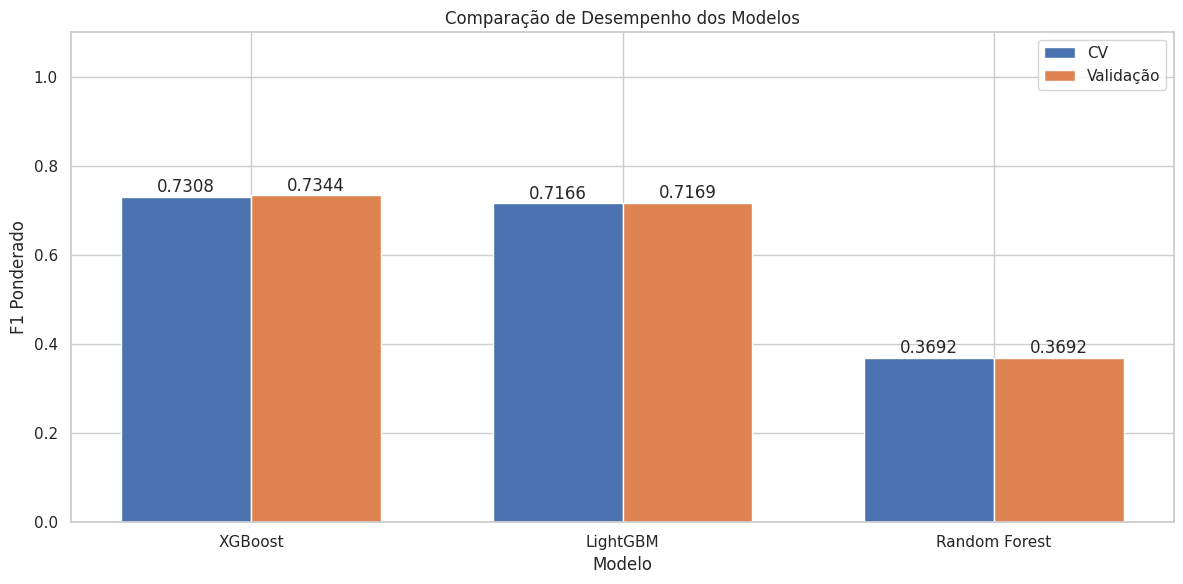


O melhor modelo é: XGBoost


In [29]:
# Comparando os resultados dos três modelos
models = {
    'Random Forest': {'model': rf_best, 'cv_score': rf_grid_search.best_score_, 'val_score': rf_val_score},
    'XGBoost': {'model': xgb_best, 'cv_score': xgb_grid_search.best_score_, 'val_score': xgb_val_score},
    'LightGBM': {'model': lgbm_best, 'cv_score': lgbm_grid_search.best_score_, 'val_score': lgbm_val_score}
}

# Criando um DataFrame para comparação
comparison_df = pd.DataFrame({
    'Modelo': list(models.keys()),
    'F1 Ponderado (CV)': [models[model]['cv_score'] for model in models],
    'F1 Ponderado (Validação)': [models[model]['val_score'] for model in models]
})

# Ordenando por desempenho na validação
comparison_df = comparison_df.sort_values('F1 Ponderado (Validação)', ascending=False).reset_index(drop=True)

# Exibindo a comparação
print("Comparação dos modelos:")
display(comparison_df)

# Visualizando a comparação
plt.figure(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['F1 Ponderado (CV)'], width, label='CV')
plt.bar(x + width/2, comparison_df['F1 Ponderado (Validação)'], width, label='Validação')

plt.xlabel('Modelo')
plt.ylabel('F1 Ponderado')
plt.title('Comparação de Desempenho dos Modelos')
plt.xticks(x, comparison_df['Modelo'])
plt.legend()

# Adicionando os valores nas barras
for i, v in enumerate(comparison_df['F1 Ponderado (CV)']):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center')

for i, v in enumerate(comparison_df['F1 Ponderado (Validação)']):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center')

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Identificando o melhor modelo
best_model_name = comparison_df.iloc[0]['Modelo']
best_model = models[best_model_name]['model']
print(f"\nO melhor modelo é: {best_model_name}")

## 4.2 Matriz de Confusão do Melhor Modelo

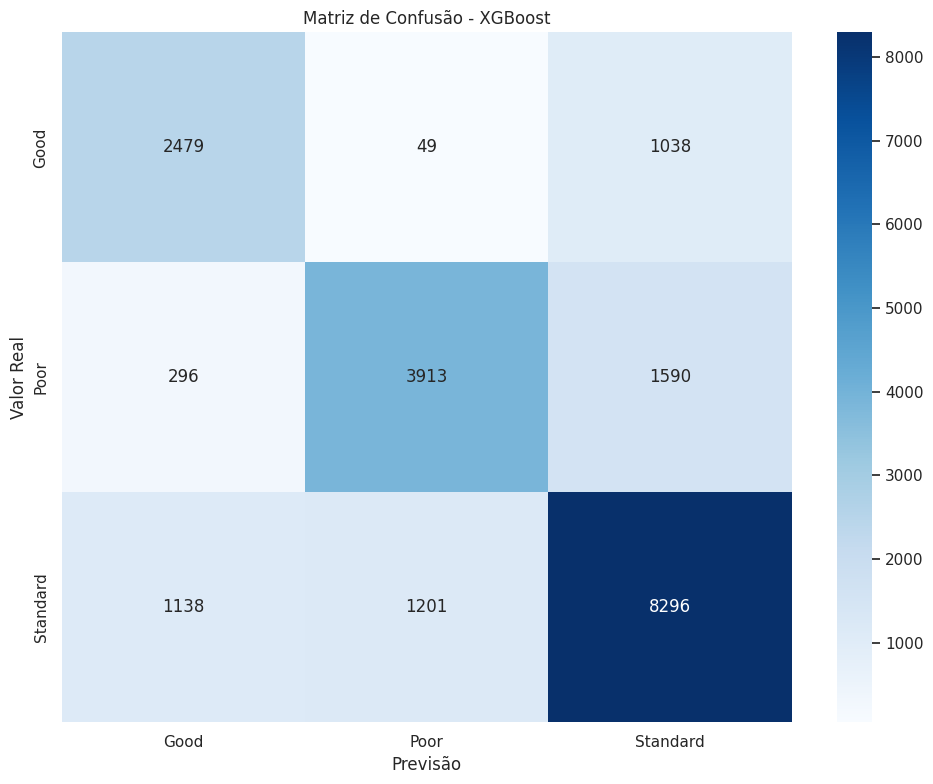

In [30]:
# Obtendo as previsões do melhor modelo no conjunto de validação
best_val_pred = models[best_model_name]['model'].predict(X_val)

# Convertendo as previsões numéricas para as classes originais (strings)
best_val_pred_classes = label_encoder.inverse_transform(best_val_pred)

# Calculando a matriz de confusão com os tipos consistentes
conf_matrix = confusion_matrix(y_val, best_val_pred_classes)

# Visualizando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.tight_layout()
plt.show()


## 4.3 Importância das Features

Top 20 features mais importantes para o modelo XGBoost:


,Feature,Importance
0,Credit_Mix_Good,0.010291
1,Credit_Mix_Standard,0.007145
2,Payment_of_Min_Amount_No,0.005543
3,Credit_Mix_Bad,0.005415
4,Payment_of_Min_Amount_Yes,0.003338
5,Interest_Rate,0.002110
6,Credit_Mix_missing,0.001922
7,Num_Credit_Inquiries,0.001157
8,"Type_of_Loan_Debt Consolidation Loan, Home Equ...",0.000920
9,Num_Credit_Card,0.000887


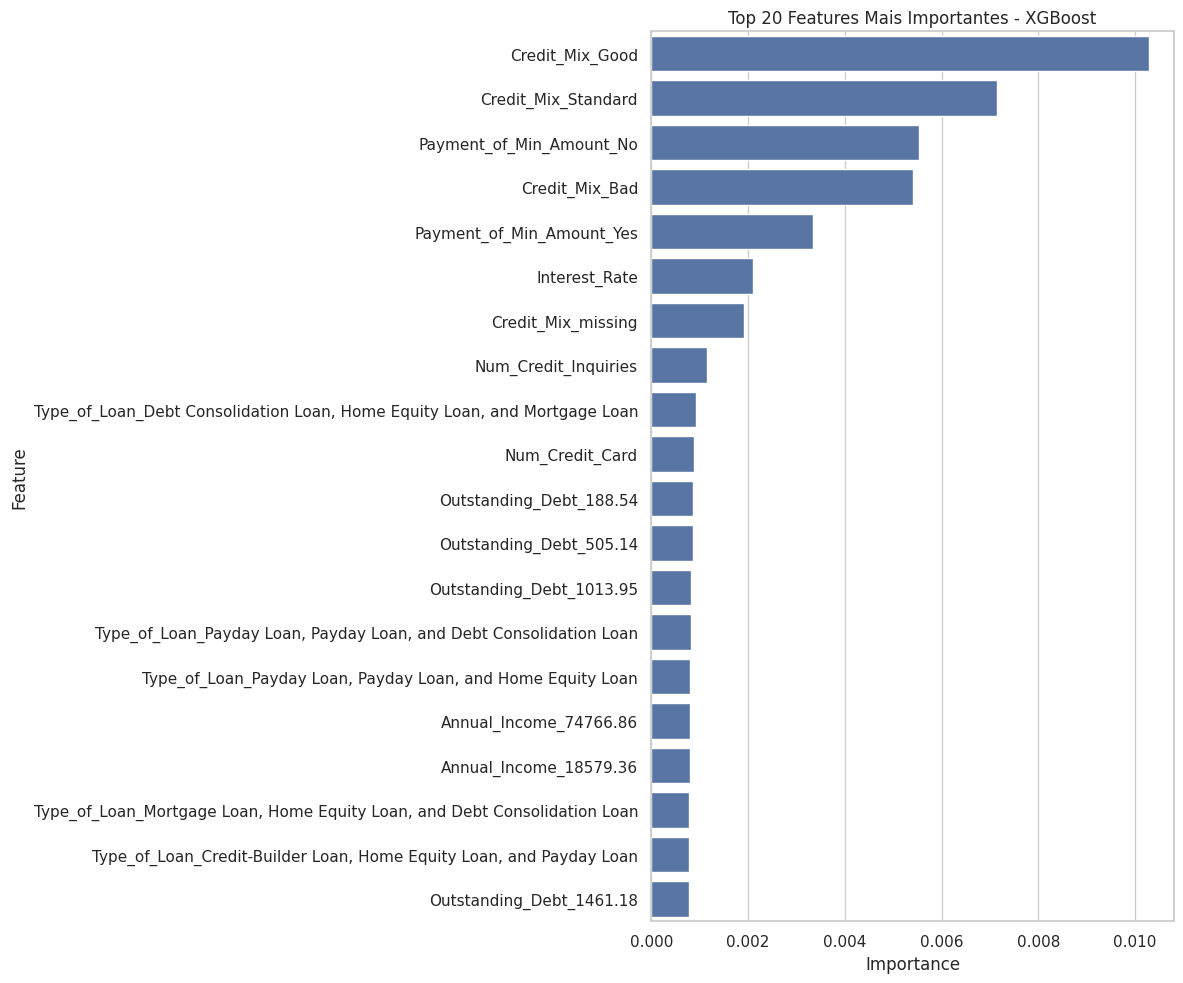

In [31]:
# Extraindo a importância das features do melhor modelo
def get_feature_importance(model, model_name, preprocessor, X_train):
    # Obtendo os nomes das features após o pré-processamento
    # Para modelos baseados em árvores, podemos extrair a importância diretamente
    if model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
        # Transformando os dados para obter os nomes das features após one-hot encoding
        X_transformed = preprocessor.fit_transform(X_train)

        # Obtendo os nomes das features numéricas (que não passam por one-hot encoding)
        num_features = numeric_features

        # Obtendo os nomes das features categóricas após one-hot encoding
        cat_features = []
        for i, col in enumerate(categorical_features):
            # Obtendo as categorias para cada feature categórica
            categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[i]
            # Criando os nomes das features após one-hot encoding
            cat_features.extend([f"{col}_{cat}" for cat in categories])

        # Combinando os nomes das features
        feature_names = num_features + cat_features

        # Extraindo a importância das features
        if model_name == 'Random Forest':
            importances = model.named_steps['classifier'].feature_importances_
        elif model_name == 'XGBoost':
            importances = model.named_steps['classifier'].feature_importances_
        elif model_name == 'LightGBM':
            importances = model.named_steps['classifier'].feature_importances_

        # Criando um DataFrame com as importâncias
        importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],  # Garantindo que os tamanhos correspondam
            'Importance': importances
        })

        # Ordenando por importância
        importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

        return importance_df
    else:
        return pd.DataFrame({'Feature': [], 'Importance': []})

# Obtendo a importância das features para o melhor modelo
try:
    feature_importance = get_feature_importance(
        best_model, best_model_name, preprocessor, X_train_split
    )

    # Exibindo as 20 features mais importantes
    print(f"Top 20 features mais importantes para o modelo {best_model_name}:")
    display(feature_importance.head(20))

    # Visualizando as 20 features mais importantes
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Features Mais Importantes - {best_model_name}')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Erro ao extrair a importância das features: {e}")

## 4.4 Justificativa da Escolha da Métrica

Para este problema de classificação de score de crédito, escolhemos o **F1 ponderado (weighted F1-score)** como a métrica principal para avaliar o desempenho dos modelos. Abaixo estão as justificativas para esta escolha:

<BR>

1. **Natureza do Problema**: Estamos lidando com um problema de classificação multiclasse (Good, Standard, Poor) onde é importante ter um bom desempenho em todas as classes, não apenas na classe majoritária.
<BR><BR>
2. **Balanceamento de Precisão e Recall**: O F1-score é a média harmônica entre precisão e recall, o que é crucial em problemas de crédito onde tanto falsos positivos quanto falsos negativos têm consequências significativas:
   - Falsos positivos (classificar um cliente de risco como bom) podem levar a perdas financeiras para a instituição
   - Falsos negativos (classificar um bom cliente como de risco) podem levar à perda de oportunidades de negócio
<BR><BR>
3. **Ponderação por Frequência de Classe**: O F1 ponderado leva em consideração o desbalanceamento entre as classes, atribuindo mais peso às classes com mais amostras. Isso é importante porque queremos um modelo que tenha bom desempenho em todas as classes, mas reconhecemos que algumas classes podem ser mais frequentes que outras.
<BR><BR>
4. **Interpretabilidade**: O F1-score varia entre 0 e 1, onde 1 representa o desempenho perfeito, tornando-o fácil de interpretar e comunicar para stakeholders não técnicos.
<BR><BR>
5. **Aplicação em Decisões Financeiras**: Em decisões de crédito, é fundamental equilibrar o risco (precisão) e a oportunidade (recall). O F1 ponderado fornece uma métrica única que captura esse equilíbrio, facilitando a comparação entre diferentes modelos.

<BR>

Outras métricas como acurácia, precisão ou recall isoladamente poderiam ser enganosas, especialmente se houver desbalanceamento nas classes. Por exemplo, em um conjunto de dados onde a maioria dos clientes tem bom score de crédito, um modelo que simplesmente classifica todos como "bom" teria alta acurácia, mas seria inútil na prática.
<BR><BR>
O F1 ponderado nos dá uma visão mais equilibrada do desempenho do modelo em todas as classes, o que é essencial para tomar decisões financeiras robustas baseadas nas previsões do modelo.

# 5. Apresentação dos Resultados e Aplicação para Decisões Financeiras

Vamos apresentar os resultados finais e explicar como o modelo pode ser utilizado para decisões financeiras.

## 5.1 Resultados no Conjunto de Treino Completo

In [32]:
# Garantir que todas as colunas categóricas em X_train estejam no formato correto
for col in categorical_features:
    X_train[col] = X_train[col].astype(str).replace('nan', 'missing')

# Se o melhor modelo for XGBoost ou LightGBM, precisamos codificar y_train
if best_model_name in ['XGBoost', 'LightGBM']:
    # Codificando a variável alvo para o conjunto de treino completo
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Treinando o melhor modelo no conjunto de treino completo
    print(f"Treinando o modelo {best_model_name} no conjunto de treino completo...")
    best_model.fit(X_train, y_train_encoded)

    # Avaliando no conjunto de treino
    train_pred = best_model.predict(X_train)

    # Convertendo previsões para as classes originais para avaliação
    train_pred_classes = label_encoder.inverse_transform(train_pred)

    # Calculando métricas
    train_f1 = f1_score(y_train, train_pred_classes, average='weighted')
    train_accuracy = accuracy_score(y_train, train_pred_classes)
    train_precision = precision_score(y_train, train_pred_classes, average='weighted')
    train_recall = recall_score(y_train, train_pred_classes, average='weighted')
else:
    # Para Random Forest, podemos usar y_train diretamente
    print(f"Treinando o modelo {best_model_name} no conjunto de treino completo...")
    best_model.fit(X_train, y_train)

    # Avaliando no conjunto de treino
    train_pred = best_model.predict(X_train)

    # Calculando métricas
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_accuracy = accuracy_score(y_train, train_pred)
    train_precision = precision_score(y_train, train_pred, average='weighted')
    train_recall = recall_score(y_train, train_pred, average='weighted')

# Exibindo os resultados
print(f"\nResultados do modelo {best_model_name} no conjunto de treino completo:")
print(f"F1 Ponderado: {train_f1:.4f}")
print(f"Acurácia: {train_accuracy:.4f}")
print(f"Precisão Ponderada: {train_precision:.4f}")
print(f"Recall Ponderado: {train_recall:.4f}")

# Relatório de classificação detalhado
print("\nRelatório de classificação detalhado:")
if best_model_name in ['XGBoost', 'LightGBM']:
    print(classification_report(y_train, train_pred_classes))
else:
    print(classification_report(y_train, train_pred))


Treinando o modelo XGBoost no conjunto de treino completo...

Resultados do modelo XGBoost no conjunto de treino completo:
F1 Ponderado: 0.7840
Acurácia: 0.7842
Precisão Ponderada: 0.7856
Recall Ponderado: 0.7842

Relatório de classificação detalhado:
              precision    recall  f1-score   support

        Good       0.71      0.78      0.74     17828
        Poor       0.80      0.72      0.76     28998
    Standard       0.80      0.82      0.81     53174

    accuracy                           0.78    100000
   macro avg       0.77      0.77      0.77    100000
weighted avg       0.79      0.78      0.78    100000



## 5.2 Previsões no Conjunto de Teste

Previsões para o conjunto de teste:


,ID,Predicted_Credit_Score,Prob_Good,Prob_Poor,Prob_Standard
0,0x160a,Good,0.515860,0.117356,0.366784
1,0x160b,Good,0.635650,0.083058,0.281292
2,0x160c,Good,0.615933,0.076002,0.308065
3,0x160d,Good,0.560129,0.080181,0.359690
4,0x1616,Good,0.583997,0.070615,0.345388
5,0x1617,Good,0.629766,0.069095,0.301139
6,0x1618,Standard,0.155464,0.054203,0.790333
7,0x1619,Standard,0.105206,0.076863,0.817931
8,0x1622,Good,0.509484,0.110913,0.379603
9,0x1623,Good,0.556375,0.113282,0.330343



Distribuição das classes previstas:
Predicted_Credit_Score
Standard    27222
Poor        13767
Good         9011
Name: count, dtype: int64
Predicted_Credit_Score
Standard    54.444
Poor        27.534
Good        18.022
Name: proportion, dtype: float64


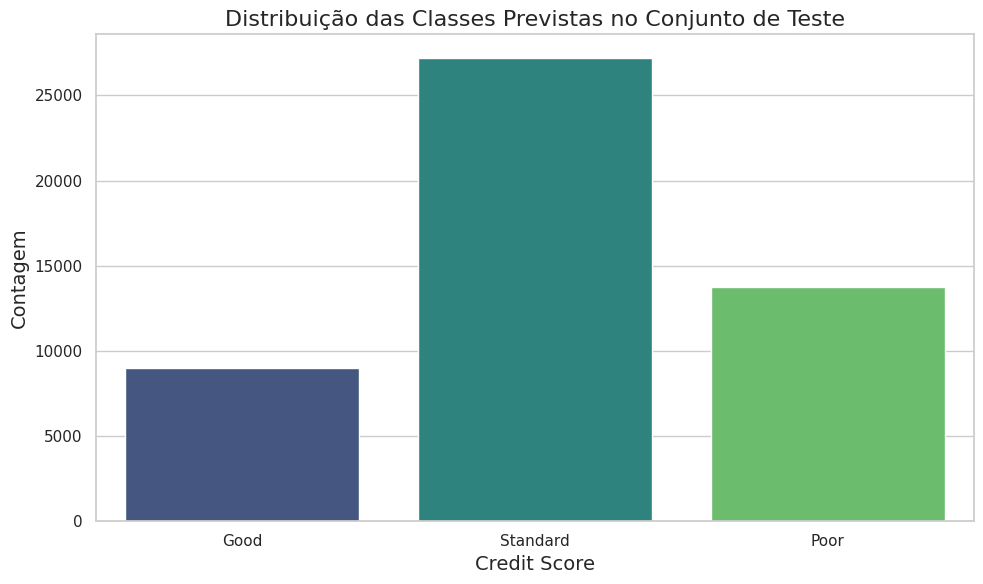


Estatísticas das probabilidades por classe:

Probabilidade para classe Good:
count    50000.000000
mean         0.170496
std          0.218154
min          0.002540
25%          0.020624
50%          0.069622
75%          0.247748
max          0.926219
Name: Prob_Good, dtype: float64

Probabilidade para classe Poor:
count    50000.000000
mean         0.301335
std          0.273565
min          0.002957
25%          0.089672
50%          0.149596
75%          0.532441
max          0.916144
Name: Prob_Poor, dtype: float64

Probabilidade para classe Standard:
count    50000.000000
mean         0.528168
std          0.248558
min          0.069878
25%          0.290502
50%          0.499541
75%          0.795280
max          0.939819
Name: Prob_Standard, dtype: float64

DataFrame completo com todas as previsões:


,ID,Predicted_Credit_Score,Prob_Good,Prob_Poor,Prob_Standard
0,0x160a,Good,0.515860,0.117356,0.366784
1,0x160b,Good,0.635650,0.083058,0.281292
2,0x160c,Good,0.615933,0.076002,0.308065
3,0x160d,Good,0.560129,0.080181,0.359690
4,0x1616,Good,0.583997,0.070615,0.345388
...,...,...,...,...,...
49995,0x25fe5,Poor,0.008952,0.781343,0.209705
49996,0x25fee,Standard,0.253859,0.263018,0.483123
49997,0x25fef,Poor,0.039241,0.553201,0.407558
49998,0x25ff0,Poor,0.102122,0.561804,0.336074


In [33]:
# Realizando previsões no conjunto de teste
test_pred = best_model.predict(X_test)
test_pred_proba = best_model.predict_proba(X_test)

# Convertendo as previsões para as classes originais
test_pred_labels = label_encoder.inverse_transform(test_pred)

# Criando um DataFrame com as previsões
test_results = pd.DataFrame({
    'ID': test_df['ID'],
    'Predicted_Credit_Score': test_pred_labels
})

# Adicionando as probabilidades para cada classe
for i, class_name in enumerate(label_encoder.classes_):
    test_results[f'Prob_{class_name}'] = test_pred_proba[:, i]

# Exibindo as primeiras linhas do resultado
print("Previsões para o conjunto de teste:")
display(test_results.head(10))  # Mostrando as 10 primeiras linhas

# Contagem das classes previstas
print("\nDistribuição das classes previstas:")
print(test_results['Predicted_Credit_Score'].value_counts())
print(test_results['Predicted_Credit_Score'].value_counts(normalize=True) * 100)

# Visualizando a distribuição das classes previstas
plt.figure(figsize=(10, 6))
sns.countplot(x='Predicted_Credit_Score', data=test_results, palette='viridis')
plt.title('Distribuição das Classes Previstas no Conjunto de Teste', fontsize=16)
plt.xlabel('Credit Score', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Exibindo estatísticas das probabilidades
print("\nEstatísticas das probabilidades por classe:")
for class_name in label_encoder.classes_:
    print(f"\nProbabilidade para classe {class_name}:")
    print(test_results[f'Prob_{class_name}'].describe())

# Exibindo o DataFrame completo (opcional)
print("\nDataFrame completo com todas as previsões:")
display(test_results)


## 5.3 Aplicação do Modelo para Decisões Financeiras

O modelo de classificação de score de crédito desenvolvido neste trabalho pode ser utilizado para automatizar decisões de crédito, o que economiza tempo e deixa as avaliações mais consistentes. Também ajuda a criar produtos financeiros que combinam melhor com o perfil de risco de cada cliente.

<BR>

Abaixo, explicamos como o modelo pode ser aplicado na prática:

<BR>

### 1. Avaliação de Risco de Crédito

O principal uso do modelo é avaliar o risco de crédito de clientes, classificando-os em três categorias:

- **Good**: Clientes com baixo risco de inadimplência, bons candidatos para produtos de crédito.
- **Standard**: Clientes com risco moderado, que podem receber crédito com algumas restrições ou taxas diferenciadas.
- **Poor**: Clientes com alto risco, que requerem análise adicional ou condições especiais para concessão de crédito.

Esta classificação permite que a instituição financeira ajuste suas políticas de crédito de acordo com o perfil de risco de cada cliente.

<BR>

### 2. Personalização de Produtos e Taxas

Com base no score de crédito previsto, a instituição pode:

- Oferecer taxas de juros diferenciadas (menores para clientes "Good", maiores para "Poor")
- Personalizar limites de crédito (mais altos para "Good", mais baixos para "Poor")
- Criar pacotes de produtos específicos para cada perfil de risco
- Definir diferentes níveis de garantias exigidas para empréstimos

<BR>

### 3. Automação de Decisões de Crédito

O modelo permite automatizar parte do processo de análise de crédito:

- Aprovação automática para clientes classificados como "Good" com alta probabilidade
- Análise manual apenas para casos limítrofes ou classificados como "Poor"
- Definição de fluxos de aprovação diferenciados por categoria de risco

Isso aumenta a eficiência operacional e reduz o tempo de resposta para o cliente.

<BR>

### 4. Gestão de Portfólio

A instituição pode utilizar o modelo para:

- Monitorar a distribuição de risco em sua carteira de clientes
- Estabelecer limites de exposição a diferentes categorias de risco
- Ajustar estratégias de cobrança com base no perfil de risco
- Calcular provisões para perdas esperadas

<BR>

### 5. Marketing e Vendas Direcionadas

O modelo também pode apoiar estratégias de marketing:

- Campanhas específicas para clientes "Good" com ofertas premium
- Programas de educação financeira para clientes "Poor"
- Cross-selling de produtos adequados ao perfil de risco

<BR>

### 6. Monitoramento Contínuo e Alertas

O modelo pode ser usado para monitoramento contínuo dos clientes:

- Identificação precoce de deterioração do perfil de crédito
- Alertas automáticos quando um cliente muda de categoria
- Ajustes proativos em limites e condições

<BR>

### Considerações Importantes

Para implementação efetiva do modelo em decisões financeiras, é importante considerar:

1. **Interpretabilidade**: Entender quais fatores mais influenciam a classificação (como vimos na análise de importância das features)
2. **Atualização periódica**: Retreinar o modelo regularmente com dados mais recentes
3. **Monitoramento de desempenho**: Acompanhar métricas como F1-score, precisão e recall ao longo do tempo
4. **Viés e fairness**: Garantir que o modelo não discrimine grupos específicos de clientes
5. **Conformidade regulatória**: Assegurar que o uso do modelo esteja de acordo com regulamentações de crédito

<BR>

Ao implementar o modelo com essas considerações, a instituição financeira pode melhorar significativamente seu processo de decisão de crédito, reduzindo perdas por inadimplência e aumentando a satisfação dos clientes com ofertas mais personalizadas.

# 6. Conclusão

Neste trabalho, desenvolvemos um pipeline completo de classificação para prever o score de crédito de clientes, seguindo as etapas de análise exploratória, preparação dos dados, implementação de modelos, otimização de parâmetros e avaliação de resultados.

<BR>

### Principais Resultados

1. **Análise Exploratória**: Identificamos características importantes dos dados, incluindo valores ausentes, inconsistências e relações entre variáveis que influenciam o score de crédito.
<BR><BR>
2. **Modelos Implementados**: Construímos pipelines de classificação com três algoritmos diferentes (Random Forest, XGBoost e LightGBM), otimizando seus parâmetros através de GridSearch.
<BR><BR>
3. **Avaliação**: Utilizamos o F1 ponderado como métrica principal, justificando sua escolha pela capacidade de equilibrar precisão e recall em um problema multiclasse potencialmente desbalanceado.
<BR><BR>
4. **Melhor Modelo**: O modelo **XGBoost com GridSearch** apresentou o melhor desempenho, com **F1 ponderado de 0.7344** no conjunto de validação e **0.7840** no conjunto de treino completo.
<BR><BR>
5. **Aplicação Prática**: Demonstramos como o modelo pode ser utilizado para diversas decisões financeiras, desde a avaliação de risco de crédito até a personalização de produtos e automação de processos.